In [3]:
import matplotlib.pyplot as plt
import numpy as np
import cvxpy as cp
import pandas as pd
import statsmodels.api as sm
from skimage.data import shepp_logan_phantom
from skimage.transform import radon, iradon, rescale

# Relatively big resolution (20x20)

In [4]:
def nthRootsOfUnity(n):
        return np.exp(2j * np.pi / n * np.arange(n))
def get_intersection(x,y):
    val = min(x[1],y[1])-max(x[0],y[0])
    if val<0:
        val = 0
    return val
def build_matrix_row(b,roots):
    roots_updated = roots-b
        
    angles=np.angle(roots-b)
    normalized_angles=(((angles-angles[0])/(2*np.pi))%1)
    normalized_angles_w_ind = list(enumerate(normalized_angles))

    detectors = normalized_angles_w_ind
    for i in range(len(detectors)):
        if i == len(detectors)-1:
            next_angle = 1
        else:
            next_angle = detectors[i+1][1]
        detectors[i]=(detectors[i][0],detectors[i][1],next_angle)
    lower = [x for x in detectors if x[1]<0.5]
    upper = [x for x in detectors if x[2]>=0.5]
    lower_shifted = [(x[0],x[1]+0.5,x[2]+0.5) for x in lower]

    D=len(roots)
    prob_lst = []
    prob_mat = np.zeros((D,D))

    iter_upper = iter(upper)
    iter_lower = iter(lower_shifted)
    detector_upper = next(iter_upper)
    detector_lower = next(iter_lower)

    while True:
        val = get_intersection((detector_upper[1],detector_upper[2]),
                         (detector_lower[1],detector_lower[2]))
        if val>1e-4:
            prob_lst.append((detector_upper[0],detector_lower[0],(2*val)))
            prob_mat[detector_upper[0],detector_lower[0]]=2*val

        try:
            if detector_upper[2]<detector_lower[2]:
                detector_upper = next(iter_upper)
            else:
                detector_lower = next(iter_lower)
        except StopIteration:
            #print("done")
            break
    prob_mat = prob_mat + prob_mat.transpose()
    #normalize the total probability is 2
    prob_mat = 2 * prob_mat / np.sum(prob_mat)
    if prob_mat.diagonal().sum():
        print("non zero diag",prob_mat.diagonal(),b)
    return prob_mat

def build_prob_matrix(B_SQRT,D):
    grid_1d=np.linspace(-1+1./B_SQRT,1-1./B_SQRT,num=B_SQRT)*np.sqrt(2)/2
    grid_2d=np.meshgrid(grid_1d,grid_1d)
    b_lst=(grid_2d[0]+grid_2d[1]*1j).flatten()
    roots = nthRootsOfUnity(D)
    P = np.zeros((B_SQRT*B_SQRT,D,D))
    for b_ind,b in enumerate(b_lst):
        P[b_ind] = build_matrix_row(b,roots)
    return P
def mse(a,b):
    return np.square(np.array(a)-np.array(b)).mean()

In [5]:
class PET:
    
    def __init__(self, B_SQRT=20,D=400, beta=0.2,tau=1e-7,T=1, f_factor=1e6,seed=2):
        self.B_SQRT=B_SQRT
        B=B_SQRT*B_SQRT
        self.B=B
        self.D=D
        self.T=T
        self.beta=beta
        self.tau=tau
        self.f_factor=f_factor
        print("random/singles photons for each detector",np.round(4*tau*beta*(1-beta)*self.f_factor,3))
        print("avr events from pixels to detector",1.*self.f_factor/(B*D))
        print("avr events from pixels to pair of detectors",1.*self.f_factor/(B*D*D))
        
        self.beta_reconstruction_results = {}
        
        self.i_upper = np.triu_indices(D,1)
        self.i_lower = np.tril_indices(D, -1)
        self.i_diag = np.diag_indices(D)
        self.i_upper_diag = np.triu_indices(D) 
        
        np.random.seed(seed)
        self.build_prob_matrix()
        self.build_true_image()
        
    def build_prob_matrix(self):
        self.P = build_prob_matrix(self.B_SQRT,self.D)
        
    def build_true_image(self):
        self.f_true = shepp_logan_phantom()
        self.f_true = rescale(self.f_true,
                              self.B_SQRT/self.f_true.shape[0])
        if (self.f_true.shape[0] != self.B_SQRT):
            print("size of f_true %d is wrong (!= %d)"%(self.f_true.shape[0],self.B_SQRT))
        self.f_true = self.f_factor * self.f_true / self.f_true.sum()
        self.f_true = self.f_true.flatten()
        
        
    def run_simulation(self):
        
        lamb = np.zeros_like(self.P)
        for b in range(self.B):
            lamb[b]=(1-self.beta)**2 *self.P[b]*self.f_true[b]
        s=self.beta*(1-self.beta)*self.P.sum(axis=2).transpose()@self.f_true
        r=2*self.tau*np.outer(s,s)
        r[self.i_diag]=0.5*r[self.i_diag]        
        
        s_norand = s-r.sum(axis=1)-r[self.i_diag]
        s_norand[s_norand<0]=0        
        n_s_norand = np.random.poisson(self.T*s_norand)        
        
        expected=(lamb.sum(axis=0)+r)
        n_star=np.random.poisson(self.T*expected)
        n_star[self.i_lower] = n_star.T[self.i_lower]
        self.s=s
        self.r=r
        self.lamb=lamb
        self.s_norand=s_norand
        self.expected = expected
        self.n_star=n_star
        self.n_s_norand = n_s_norand
    
    def plot_singles(self):
        plt.title("windows size percentage of a single for each detector")
        plt.plot(2*self.tau*self.s, label='s')
        plt.ylim([0,1])
        plt.legend(loc=0)
        plt.show()
        
        plt.title("single rates, signles that cause randoms and the singles that dont cause randoms")
        plt.plot(self.s, label='s')
        plt.plot(self.r.sum(axis=1)+self.r[self.i_diag],label='r')
        plt.plot(self.s_norand,label='s-r')        
        plt.legend(loc=0)
        plt.show()
        
        plt.title("signles that cause randoms and the singles that dont cause randoms")        
        plt.plot(self.r.sum(axis=1)+self.r[self.i_diag],label='r')
        plt.plot(self.s_norand,label='s-r')        
        plt.legend(loc=0)
        plt.show()
                    
    def reconstruct_known_beta(self, num_iter=50,solver_eps=1e-5,use_beta=None):
        
        if use_beta == None:
            beta = self.beta
        else:
            beta = use_beta
        
        print(f"Reconstruction using the new method, beta {beta}")
        
        # Initialize log-likelihood and MSE lists
        f_lst = []
        llik_lst=[]
        mse_lst=[]
        
        lamb_curr=np.zeros_like(self.P)
        f_curr = np.ones(self.B)*float(self.n_star.sum())/(2*self.B)
        llik_true = -self.T*self.expected[self.i_upper_diag].sum()+ \
                     np.dot(self.n_star[self.i_upper_diag],
                            np.log(self.expected[self.i_upper_diag]))

        for i in range(num_iter):
            lamb_curr = np.zeros_like(self.P)
            for b in range(self.B):
                lamb_curr[b]=(1-beta)**2 *self.P[b]*f_curr[b]
                    
            s_curr=beta*(1-beta)*self.P.sum(axis=2).transpose()@f_curr
            r_curr=2*self.tau*np.outer(s_curr,s_curr)
            r_curr[self.i_diag]=0.5*r_curr[self.i_diag]

            expected_curr = lamb_curr.sum(axis=0)+r_curr
            d_curr = np.divide(self.n_star,expected_curr, 
                               out=np.zeros_like(expected_curr), where=self.n_star!=0)
            nr_curr  = r_curr*d_curr

            n_curr=np.zeros_like(self.P)
            for b in range(self.B):
                n_curr[b]=lamb_curr[b]*d_curr

            llik = -self.T*expected_curr[self.i_upper_diag].sum()+ \
                    np.dot(self.n_star[self.i_upper_diag],np.log(expected_curr[self.i_upper_diag])) \
                    - llik_true            
            
            # Factor model portfolio optimization.
            f = cp.Variable(self.B,nonneg=True)
            
            obj =  -self.T*(1-beta)**2 *cp.sum(f) \
                    + 0.5*cp.scalar_product(n_curr.sum(axis=(1,2)),cp.log(f)) \
                    -self.T*4*self.tau*(beta)**2 * (1-beta)**2 *cp.square(cp.sum(f)) \
                    + cp.scalar_product(nr_curr.sum(axis=1)+nr_curr[self.i_diag],\
                                        cp.log(self.P.sum(axis=2).transpose()@f))  

            prob = cp.Problem(cp.Maximize(obj))

            prob.solve(solver='SCS',verbose=False, eps=solver_eps)
            if prob.status != "optimal":
                print(i,"status",prob.status)                        
            
            mse_curr=mse(f.value,self.f_true)
            if i==0:
                diff_llik=0.0
                diff_mse=0.0
            else:
                diff_llik=llik - llik_lst[-1]
                diff_mse=mse_curr-mse_lst[-1]
            
                print(i,"llik ",llik.round(2),\
                      "diff llik",round(diff_llik,2),\
                      "mse",mse_curr.round(2),\
                      "diff mse",round(diff_mse,2),\
                     "f sum",f.value.sum().round(2))

            f_lst.append(f.value)
            llik_lst.append(llik)
            mse_lst.append(mse_curr)
            
            f_curr=f.value           
            
            llik_diff_tolerance=1
            if (i>0) and (diff_llik<llik_diff_tolerance):
                print("stopping because diff_llik=%.2f<%.2f"%(diff_llik,llik_diff_tolerance))
                break
        
        self.mse3 = mse_curr
        self.beta_reconstruction_results[beta] = [llik_lst,mse_lst,f_lst]
        return llik_lst,mse_lst,f_lst                      
    
    def reconstruct_all_beta(self, num_iter=50,solver_eps=1e-5,beta_lst=np.arange(0.05,0.3,0.03)):
        
        for beta in beta_lst:
            llik_lst,mse_lst,f_lst = self.reconstruct_known_beta(num_iter,solver_eps,beta)
            
        best_mse_beta = min(self.beta_reconstruction_results, key=lambda x: self.beta_reconstruction_results[x][1][-1])
        print(f"Beta with the best MSE: {best_mse_beta}")

        # Find the beta with the best log-likelihood
        best_llik_beta = max(self.beta_reconstruction_results, key=lambda x: self.beta_reconstruction_results[x][0][-1])
        print(f"Beta with the best log-likelihood: {best_llik_beta} "\
              f"with llik {np.round(self.beta_reconstruction_results[best_llik_beta][0][-1],2)}"\
              f" and mse  {np.round(self.beta_reconstruction_results[best_llik_beta][1][-1],2)}")        
        
    def plot_results_one_beta(self,use_beta=None):
        if use_beta == None:
            beta = self.beta
        else:
            beta = use_beta
            
        fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

        # Plot the MSE graph
        axs[0].set_xlabel('iteration')
        axs[0].set_ylabel('MSE from the true image')
        
        llik_lst, mse_lst, f_lst = self.beta_reconstruction_results[beta]
        axs[0].plot(range(len(mse_lst)), mse_lst)
        

        # Plot the llik graph
        axs[1].set_xlabel('iteration')
        axs[1].set_ylabel('Log likelihood difference from the true image')
        
        llik_lst, mse_lst, f_lst = self.beta_reconstruction_results[beta]
        axs[1].plot(range(len(llik_lst)), llik_lst)
        axs[1].legend()

        # Set the overall title for the figure
        fig.suptitle("MSE and Log-likelihood convergence")
        
    def plot_results_many_beta(self):
        beta_lst=list(self.beta_reconstruction_results.keys())
        
        # Create a dictionary to hold the results
        results_dict = {"beta": [], "MSE": [], "Log-likelihood": []}

        # Loop through the results and add them to the dictionary
        for beta, results in self.beta_reconstruction_results.items():
            mse_last = results[1][-1]
            llik_last = results[0][-1]
            results_dict["beta"].append(beta)
            results_dict["MSE"].append(mse_last)
            results_dict["Log-likelihood"].append(llik_last)

        # Create the dataframe
        results_df = pd.DataFrame(results_dict)

        # Print the dataframe
        print(results_df)
        
        fig, ax1 = plt.subplots()

        ax1.set_xlabel('beta')
        ax1.set_ylabel('MSE from the true image')
        ax1.plot(beta_lst, [self.beta_reconstruction_results[beta][1][-1] for beta in beta_lst], 'o-', color='tab:blue')
        ax1.tick_params(axis='y', labelcolor='tab:blue')

        ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

        ax2.set_ylabel('Log likelihood difference from the true image')
        ax2.plot(beta_lst, [self.beta_reconstruction_results[beta][0][-1] for beta in beta_lst], 'o-', color='tab:orange')
        ax2.tick_params(axis='y', labelcolor='tab:orange')

        fig.tight_layout()  # otherwise the right y-label is slightly clipped
        plt.show()
        
        fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

        # Plot the MSE graph
        axs[0].set_xlabel('iteration')
        axs[0].set_ylabel('MSE from the true image')
        for beta in beta_lst:
            llik_lst, mse_lst, f_lst = self.beta_reconstruction_results[beta]
            axs[0].plot(range(len(mse_lst)), mse_lst, label=f'Beta={beta}')
        axs[0].legend()

        # Plot the llik graph
        axs[1].set_xlabel('iteration')
        axs[1].set_ylabel('Log likelihood difference from the true image')
        for beta in beta_lst:
            llik_lst, mse_lst, f_lst = self.beta_reconstruction_results[beta]
            axs[1].plot(range(len(llik_lst)), llik_lst, label=f'Beta={beta}')
        axs[1].legend()

        # Set the overall title for the figure
        fig.suptitle("MSE and Log-likelihood convergence")

    def reconstruct_prior_methods(self,fix_randoms=False):
        print("Reconstruction using prior methods")

        P_tri = np.stack([self.P[x][self.i_upper] for x in range(self.B)]).transpose()
        non_zero_rows=(P_tri.sum(axis=1)!=0)
        mat=self.T*(1-self.beta)**2 *P_tri[non_zero_rows]        

        if not fix_randoms:
            print("without fixing random")
            y=(self.n_star)[self.i_upper][non_zero_rows]
            method="lbfgs"
        else:
            print("with fixing random")
            
            #plt.plot(self.s,label="real value",color="black")
            s_est = (self.n_s_norand+self.n_star.sum(axis=0)+self.n_star[self.i_diag])/self.T
            r_est=2*self.tau*np.outer(s_est,s_est)
            r_est[self.i_diag]=0.5*self.n_star[self.i_diag]
            
            #plt.plot(s_est,label="basic method",color="red")
            #plt.legend(loc=0)
            #plt.show()
            
            # The diagonal is not fixed because it is not used later

            y=(self.n_star-self.T*r_est)[self.i_upper][non_zero_rows]
            method="IRLS"
            
        poiReg = sm.GLM(y, mat, family = sm.families.Poisson(link = sm.families.links.identity())).fit(method=method)
        curr_mse=mse(poiReg.params,self.f_true)
        print("mse",curr_mse.round(2))
        #plt.imshow(poiReg.params.reshape(self.B_SQRT,self.B_SQRT), cmap='Greys_r')
        #plt.show()
        
        if not fix_randoms:
            self.mse1=curr_mse
        else:
            self.mse2=curr_mse
    def run_all(self,num_iter=50,solver_eps=1e-5):
    
        self.run_simulation()
        self.reconstruct_prior_methods(fix_randoms=False)
        self.reconstruct_prior_methods(fix_randoms=True)
        self.reconstruct_known_beta(num_iter=num_iter,solver_eps=solver_eps)
        
        return (self.mse1,self.mse2,self.mse3)
        
        #self.plot_results()      

random/singles photons for each detector 0.001
avr events from pixels to detector 6.25
avr events from pixels to pair of detectors 0.015625
Reconstruction using prior methods
with fixing random


C:\Users\igali\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\genmod\generalized_linear_model.py:308: DomainWarning: The identity link function does not respect the domain of the Poisson family.
  warnings.warn((f"The {type(family.link).__name__} link function "


mse 135171.1
Reconstruction using the new method, beta 0.8
1 llik  -4761.9 diff llik 96790.59 mse 835642.73 diff mse -1631085.86 f sum 1015957.13
2 llik  -2112.5 diff llik 2649.4 mse 330294.05 diff mse -505348.69 f sum 1030814.32
3 llik  -962.08 diff llik 1150.42 mse 220684.46 diff mse -109609.58 f sum 1002255.35
4 llik  -433.24 diff llik 528.84 mse 155448.73 diff mse -65235.73 f sum 1025736.19
5 llik  -198.73 diff llik 234.51 mse 161423.31 diff mse 5974.58 f sum 1027818.84
6 llik  -74.65 diff llik 124.08 mse 177808.45 diff mse 16385.14 f sum 1042168.5
7 llik  -29.6 diff llik 45.05 mse 212804.95 diff mse 34996.5 f sum 1037660.49
8 llik  -2.47 diff llik 27.13 mse 196727.33 diff mse -16077.63 f sum 1032989.67
9 llik  34.84 diff llik 37.32 mse 192546.21 diff mse -4181.12 f sum 1039541.45
10 llik  41.91 diff llik 7.07 mse 201107.87 diff mse 8561.67 f sum 1030431.86
11 llik  63.35 diff llik 21.44 mse 191264.11 diff mse -9843.77 f sum 1036885.73
12 llik  65.12 diff llik 1.76 mse 182318.39 di

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


16 llik  66.61 diff llik -16.39 mse 180683.56 diff mse -2377.35 f sum 1034491.28
stopping because diff_llik=-16.39<1.00


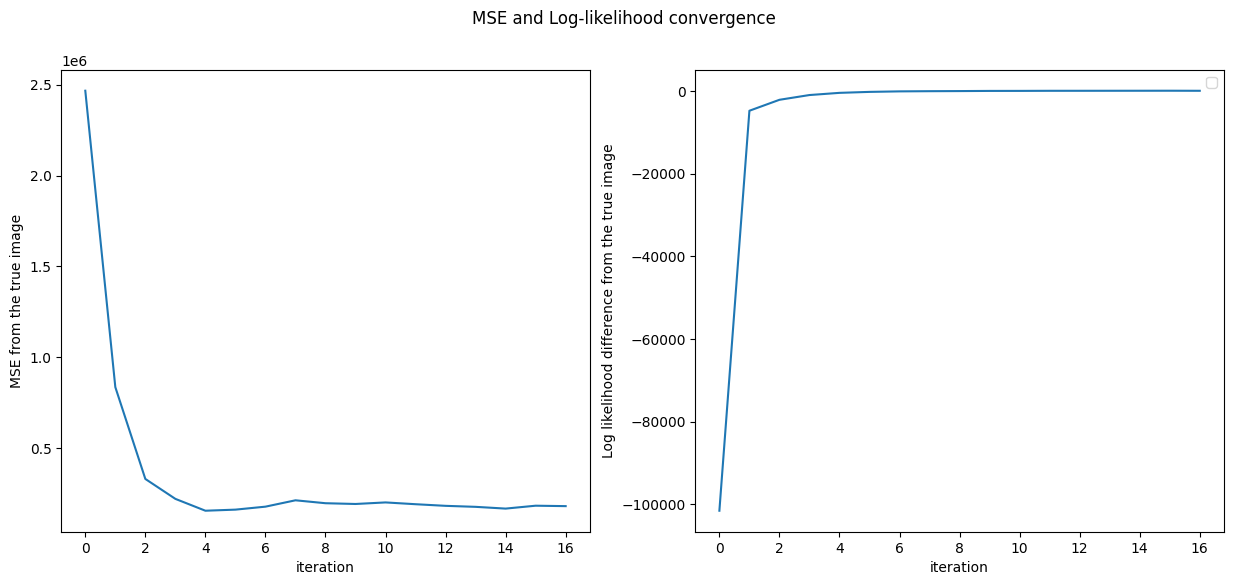

In [12]:
# Example for running a single reconstruction
pet=PET(f_factor=1e6,tau=1e-9,T=1,beta=0.8)
pet.run_simulation()
pet.reconstruct_prior_methods(fix_randoms=True)
pet.reconstruct_known_beta(num_iter=50,solver_eps=1e-5)
pet.plot_results_one_beta()  

In [60]:
# Running on mupliple parameters, several times for each one, and collecting the results
f_factor_values = []
tau_values = []
T_values = []
beta_values = []
mse1_values = []
mse2_values = []
mse3_values = []

# Define the range of values for f_factor, tau, and T
f_factor_range = [1e5,5e5,1e6] 
tau_range = [1e-9]
T_range = [0.1,0.5,1]
beta_range=[0.8]

# Step 5: Iterate over the combinations of f_factor, tau, and T values
for f_factor in f_factor_range:
    for tau in tau_range:
        for T in T_range:
            for beta in beta_range:
                mse1, mse2, mse3 = PET(f_factor=f_factor,tau=tau,T=T,beta=0.8).run_all()
                # Append the values to their respective lists
                f_factor_values.append(f_factor)
                tau_values.append(tau)
                T_values.append(T)
                beta_values.append(beta)
                mse1_values.append(mse1)
                mse2_values.append(mse2)
                mse3_values.append(mse3)

df_results = pd.DataFrame({
    'f_factor': f_factor_values,
    'tau': tau_values,
    'T': T_values,
    'beta':beta_values,
    'mse1': mse1_values,
    'mse2': mse2_values,
    'mse3': mse3_values
})
df_results

random/singles photons for each detector 0.0
avr events from pixels to detector 0.625
avr events from pixels to pair of detectors 0.0015625
Reconstruction using prior methods
without fixing random


/home/ubuntu/.local/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:298: DomainWarning: The identity link function does not respect the domain of the Poisson family.
  warnings.warn((f"The {type(family.link).__name__} link function "
/home/ubuntu/.local/lib/python3.8/site-packages/statsmodels/genmod/families/family.py:458: RuntimeWarning: invalid value encountered in log
  return var_weights / scale * (endog * np.log(mu) - mu -
/home/ubuntu/.local/lib/python3.8/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/ubuntu/.local/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1142: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


mse 7222335.59
Reconstruction using prior methods
with fixing random


/home/ubuntu/.local/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:298: DomainWarning: The identity link function does not respect the domain of the Poisson family.
  warnings.warn((f"The {type(family.link).__name__} link function "


mse 1855915.06
Reconstruction using the new method, beta 0.8


/home/ubuntu/.local/lib/python3.8/site-packages/cvxpy/atoms/elementwise/log.py:35: RuntimeWarning: divide by zero encountered in log
  return np.log(values[0])
/home/ubuntu/.local/lib/python3.8/site-packages/cvxpy/atoms/affine/binary_operators.py:273: RuntimeWarning: invalid value encountered in multiply
  return np.multiply(values[0], values[1])


1 llik  18.01 diff llik 2090.5 mse 52149.1 diff mse 13908.08 f sum 107951.89
2 llik  63.77 diff llik 45.76 mse 71539.01 diff mse 19389.91 f sum 107937.5
3 llik  82.84 diff llik 19.06 mse 86619.66 diff mse 15080.65 f sum 107963.19
4 llik  92.04 diff llik 9.21 mse 97024.28 diff mse 10404.62 f sum 107960.21
5 llik  97.06 diff llik 5.01 mse 104789.29 diff mse 7765.01 f sum 107979.55
6 llik  100.02 diff llik 2.96 mse 110270.76 diff mse 5481.47 f sum 107972.0
7 llik  101.89 diff llik 1.88 mse 114366.52 diff mse 4095.76 f sum 107962.47
8 llik  103.15 diff llik 1.26 mse 117496.73 diff mse 3130.2 f sum 107969.22
9 llik  104.02 diff llik 0.87 mse 119941.42 diff mse 2444.69 f sum 107969.16
stopping because diff_llik=0.87<1.00
random/singles photons for each detector 0.0
avr events from pixels to detector 0.625
avr events from pixels to pair of detectors 0.0015625
Reconstruction using prior methods
without fixing random


/home/ubuntu/.local/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:298: DomainWarning: The identity link function does not respect the domain of the Poisson family.
  warnings.warn((f"The {type(family.link).__name__} link function "
/home/ubuntu/.local/lib/python3.8/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


mse 72891.18
Reconstruction using prior methods
with fixing random


/home/ubuntu/.local/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:298: DomainWarning: The identity link function does not respect the domain of the Poisson family.
  warnings.warn((f"The {type(family.link).__name__} link function "


mse 35337.06
Reconstruction using the new method, beta 0.8
1 llik  -168.16 diff llik 6176.5 mse 18410.36 diff mse -9462.86 f sum 98812.93
2 llik  -12.93 diff llik 155.23 mse 19326.48 diff mse 916.13 f sum 98815.57
3 llik  53.42 diff llik 66.35 mse 22009.53 diff mse 2683.05 f sum 98811.6
4 llik  83.96 diff llik 30.54 mse 24301.46 diff mse 2291.93 f sum 98814.64
5 llik  99.52 diff llik 15.56 mse 25983.69 diff mse 1682.23 f sum 98814.82
6 llik  108.2 diff llik 8.68 mse 27231.32 diff mse 1247.62 f sum 98813.59
7 llik  113.43 diff llik 5.22 mse 28349.37 diff mse 1118.05 f sum 98823.73
8 llik  116.76 diff llik 3.33 mse 28855.64 diff mse 506.27 f sum 98792.93
9 llik  119.01 diff llik 2.25 mse 29417.99 diff mse 562.35 f sum 98813.75
10 llik  120.57 diff llik 1.56 mse 30062.43 diff mse 644.44 f sum 98823.04
11 llik  121.69 diff llik 1.12 mse 30243.26 diff mse 180.83 f sum 98790.86
12 llik  122.54 diff llik 0.84 mse 30757.95 diff mse 514.69 f sum 98823.64
stopping because diff_llik=0.84<1.00
ran

/home/ubuntu/.local/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:298: DomainWarning: The identity link function does not respect the domain of the Poisson family.
  warnings.warn((f"The {type(family.link).__name__} link function "
/home/ubuntu/.local/lib/python3.8/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


mse 51340.87
Reconstruction using prior methods
with fixing random


/home/ubuntu/.local/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:298: DomainWarning: The identity link function does not respect the domain of the Poisson family.
  warnings.warn((f"The {type(family.link).__name__} link function "


mse 17084.29
Reconstruction using the new method, beta 0.8
1 llik  -393.8 diff llik 9598.97 mse 15645.61 diff mse -12593.98 f sum 99158.14
2 llik  -118.62 diff llik 275.18 mse 12969.31 diff mse -2676.3 f sum 99171.88
3 llik  3.11 diff llik 121.73 mse 13137.68 diff mse 168.38 f sum 99158.08
4 llik  60.09 diff llik 56.97 mse 13774.57 diff mse 636.88 f sum 99161.05
5 llik  88.56 diff llik 28.48 mse 14367.02 diff mse 592.45 f sum 99160.59
6 llik  103.87 diff llik 15.31 mse 14821.71 diff mse 454.69 f sum 99160.75
7 llik  112.63 diff llik 8.77 mse 15179.95 diff mse 358.24 f sum 99160.33
8 llik  117.95 diff llik 5.31 mse 15452.75 diff mse 272.81 f sum 99160.07
9 llik  121.32 diff llik 3.38 mse 15646.25 diff mse 193.5 f sum 99160.68
10 llik  123.56 diff llik 2.24 mse 15819.09 diff mse 172.84 f sum 99160.38
11 llik  125.11 diff llik 1.54 mse 15933.58 diff mse 114.49 f sum 99160.67
12 llik  126.2 diff llik 1.09 mse 16036.85 diff mse 103.27 f sum 99159.9
13 llik  127.0 diff llik 0.8 mse 16116.78 

/home/ubuntu/.local/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:298: DomainWarning: The identity link function does not respect the domain of the Poisson family.
  warnings.warn((f"The {type(family.link).__name__} link function "
/home/ubuntu/.local/lib/python3.8/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


mse 5843001.95
Reconstruction using prior methods
with fixing random


/home/ubuntu/.local/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:298: DomainWarning: The identity link function does not respect the domain of the Poisson family.
  warnings.warn((f"The {type(family.link).__name__} link function "


mse 889723.66
Reconstruction using the new method, beta 0.8
1 llik  -167.99 diff llik 9317.75 mse 469690.41 diff mse -226747.19 f sum 492918.63
2 llik  -12.61 diff llik 155.38 mse 508087.13 diff mse 38396.71 f sum 492850.74
3 llik  53.41 diff llik 66.02 mse 549938.18 diff mse 41851.05 f sum 492101.0
4 llik  83.91 diff llik 30.5 mse 606021.28 diff mse 56083.1 f sum 492662.46
5 llik  99.27 diff llik 15.36 mse 666729.35 diff mse 60708.07 f sum 493076.56
6 llik  108.05 diff llik 8.78 mse 709019.09 diff mse 42289.74 f sum 492917.93
7 llik  113.09 diff llik 5.03 mse 722967.84 diff mse 13948.75 f sum 490174.12
8 llik  116.55 diff llik 3.46 mse 723559.18 diff mse 591.33 f sum 492032.56
9 llik  118.77 diff llik 2.22 mse 726280.4 diff mse 2721.23 f sum 492108.82
10 llik  120.22 diff llik 1.45 mse 735431.9 diff mse 9151.5 f sum 492057.35
11 llik  121.25 diff llik 1.03 mse 765327.95 diff mse 29896.05 f sum 492971.8
12 llik  122.49 diff llik 1.24 mse 785893.48 diff mse 20565.53 f sum 492858.88
13 l

/home/ubuntu/.local/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:298: DomainWarning: The identity link function does not respect the domain of the Poisson family.
  warnings.warn((f"The {type(family.link).__name__} link function "
/home/ubuntu/.local/lib/python3.8/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


mse 223353.06
Reconstruction using prior methods
with fixing random


/home/ubuntu/.local/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:298: DomainWarning: The identity link function does not respect the domain of the Poisson family.
  warnings.warn((f"The {type(family.link).__name__} link function "


mse 178775.28
Reconstruction using the new method, beta 0.8


/home/ubuntu/.local/lib/python3.8/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


1 status optimal_inaccurate
1 llik  -1104.9 diff llik 30970.6 mse 274654.31 diff mse -360537.14 f sum 500114.07
2 status optimal_inaccurate
2 llik  -431.18 diff llik 673.72 mse 188459.01 diff mse -86195.3 f sum 499969.64
3 llik  -142.49 diff llik 288.69 mse 159433.16 diff mse -29025.85 f sum 500090.86
4 status optimal_inaccurate
4 llik  -7.71 diff llik 134.78 mse 166175.29 diff mse 6742.13 f sum 500220.71
5 llik  55.08 diff llik 62.79 mse 163408.39 diff mse -2766.9 f sum 500292.53
6 status optimal_inaccurate
6 llik  91.37 diff llik 36.29 mse 170865.62 diff mse 7457.24 f sum 500108.03
7 llik  108.75 diff llik 17.38 mse 167895.22 diff mse -2970.41 f sum 500466.92
8 status optimal_inaccurate
8 llik  121.47 diff llik 12.72 mse 184131.73 diff mse 16236.51 f sum 500043.18
9 llik  125.81 diff llik 4.34 mse 171848.12 diff mse -12283.61 f sum 500222.4
10 llik  133.03 diff llik 7.22 mse 204861.26 diff mse 33013.14 f sum 531456.32
11 status optimal_inaccurate
11 llik  117.51 diff llik -15.52 mse 

/home/ubuntu/.local/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:298: DomainWarning: The identity link function does not respect the domain of the Poisson family.
  warnings.warn((f"The {type(family.link).__name__} link function "
/home/ubuntu/.local/lib/python3.8/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


mse 103355.86
Reconstruction using prior methods
with fixing random


/home/ubuntu/.local/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:298: DomainWarning: The identity link function does not respect the domain of the Poisson family.
  warnings.warn((f"The {type(family.link).__name__} link function "


mse 87469.89
Reconstruction using the new method, beta 0.8
1 llik  -2312.13 diff llik 47632.32 mse 256420.23 diff mse -384521.97 f sum 492852.79
2 llik  -985.88 diff llik 1326.24 mse 135154.14 diff mse -121266.09 f sum 492435.54
3 status optimal_inaccurate
3 llik  -403.39 diff llik 582.49 mse 98220.95 diff mse -36933.19 f sum 492321.14
4 llik  -139.84 diff llik 263.55 mse 91393.52 diff mse -6827.43 f sum 491261.22
5 llik  -13.61 diff llik 126.23 mse 86466.88 diff mse -4926.64 f sum 499492.87
6 llik  52.66 diff llik 66.27 mse 87514.28 diff mse 1047.4 f sum 491494.12
7 llik  90.25 diff llik 37.59 mse 88496.04 diff mse 981.75 f sum 491963.34
8 llik  111.22 diff llik 20.97 mse 90127.66 diff mse 1631.62 f sum 492013.24
9 llik  122.62 diff llik 11.4 mse 88398.78 diff mse -1728.88 f sum 493494.85
10 llik  134.39 diff llik 11.77 mse 89161.53 diff mse 762.75 f sum 492332.64
11 llik  137.51 diff llik 3.12 mse 86668.11 diff mse -2493.42 f sum 499774.59
12 llik  141.11 diff llik 3.6 mse 85577.09 d

/home/ubuntu/.local/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:298: DomainWarning: The identity link function does not respect the domain of the Poisson family.
  warnings.warn((f"The {type(family.link).__name__} link function "
/home/ubuntu/.local/lib/python3.8/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


mse 3840603.98
Reconstruction using prior methods
with fixing random


/home/ubuntu/.local/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:298: DomainWarning: The identity link function does not respect the domain of the Poisson family.
  warnings.warn((f"The {type(family.link).__name__} link function "


mse 1593076.15
Reconstruction using the new method, beta 0.8
1 llik  -384.61 diff llik 18575.37 mse 1633294.35 diff mse -1254663.85 f sum 988161.81
2 status optimal_inaccurate
2 llik  -118.29 diff llik 266.32 mse 1295334.16 diff mse -337960.18 f sum 988786.09
3 llik  -1.73 diff llik 116.56 mse 1285955.68 diff mse -9378.48 f sum 985650.55
4 llik  55.91 diff llik 57.64 mse 1318684.43 diff mse 32728.75 f sum 919685.97
5 llik  70.81 diff llik 14.9 mse 1337818.58 diff mse 19134.15 f sum 983842.56
6 llik  97.55 diff llik 26.75 mse 1425558.29 diff mse 87739.71 f sum 978428.36
7 llik  106.38 diff llik 8.82 mse 1477111.32 diff mse 51553.03 f sum 982722.34
8 llik  111.71 diff llik 5.33 mse 1594772.88 diff mse 117661.56 f sum 989083.2
9 llik  112.59 diff llik 0.87 mse 1647314.13 diff mse 52541.26 f sum 988859.01
stopping because diff_llik=0.87<1.00
random/singles photons for each detector 0.001
avr events from pixels to detector 6.25
avr events from pixels to pair of detectors 0.015625
Reconstruc

/home/ubuntu/.local/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:298: DomainWarning: The identity link function does not respect the domain of the Poisson family.
  warnings.warn((f"The {type(family.link).__name__} link function "
/home/ubuntu/.local/lib/python3.8/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


mse 815728.12
Reconstruction using prior methods
with fixing random


/home/ubuntu/.local/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:298: DomainWarning: The identity link function does not respect the domain of the Poisson family.
  warnings.warn((f"The {type(family.link).__name__} link function "


mse 352858.42
Reconstruction using the new method, beta 0.8
1 llik  -2340.07 diff llik 61260.91 mse 943168.04 diff mse -1595906.94 f sum 984748.92
2 status optimal_inaccurate
2 llik  -982.29 diff llik 1357.78 mse 763283.49 diff mse -179884.55 f sum 986019.19
3 status optimal_inaccurate
3 llik  -456.85 diff llik 525.44 mse 535278.82 diff mse -228004.67 f sum 991523.85
4 status optimal_inaccurate
4 llik  -204.98 diff llik 251.87 mse 332222.44 diff mse -203056.38 f sum 987354.84
5 llik  -19.74 diff llik 185.24 mse 358458.78 diff mse 26236.33 f sum 1009935.87
6 status optimal_inaccurate
6 llik  47.24 diff llik 66.98 mse 511901.86 diff mse 153443.08 f sum 990360.22
7 llik  26.97 diff llik -20.27 mse 349395.46 diff mse -162506.4 f sum 1009186.95
stopping because diff_llik=-20.27<1.00
random/singles photons for each detector 0.001
avr events from pixels to detector 6.25
avr events from pixels to pair of detectors 0.015625
Reconstruction using prior methods
without fixing random


/home/ubuntu/.local/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:298: DomainWarning: The identity link function does not respect the domain of the Poisson family.
  warnings.warn((f"The {type(family.link).__name__} link function "
/home/ubuntu/.local/lib/python3.8/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


mse 143361.18
Reconstruction using prior methods
with fixing random


/home/ubuntu/.local/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:298: DomainWarning: The identity link function does not respect the domain of the Poisson family.
  warnings.warn((f"The {type(family.link).__name__} link function "


mse 135089.94
Reconstruction using the new method, beta 0.8
0 status optimal_inaccurate
1 llik  -4852.89 diff llik 96699.6 mse 969578.78 diff mse -1600428.6 f sum 1023215.47
2 llik  -2255.56 diff llik 2597.33 mse 426051.9 diff mse -543526.88 f sum 1020508.56
3 llik  -1069.56 diff llik 1186.0 mse 219833.9 diff mse -206218.0 f sum 1008701.45
4 llik  -474.01 diff llik 595.55 mse 160605.14 diff mse -59228.76 f sum 1010713.08
5 llik  -201.97 diff llik 272.04 mse 152603.75 diff mse -8001.39 f sum 1010529.64
6 llik  -67.81 diff llik 134.17 mse 154660.17 diff mse 2056.42 f sum 1014270.91
7 llik  1.89 diff llik 69.7 mse 159372.43 diff mse 4712.26 f sum 1012057.3
8 llik  41.85 diff llik 39.96 mse 165992.56 diff mse 6620.13 f sum 1012890.45
9 llik  63.22 diff llik 21.37 mse 165803.56 diff mse -189.0 f sum 1014838.91
10 llik  77.31 diff llik 14.1 mse 164878.32 diff mse -925.24 f sum 1012931.44
11 llik  88.06 diff llik 10.75 mse 169070.46 diff mse 4192.14 f sum 1014418.51
12 llik  92.58 diff llik 4

,f_factor,tau,T,beta,mse1,mse2,mse3
0,100000.0,1.000000e-09,0.1,0.8,7.222336e+06,1.855915e+06,1.199414e+05
1,100000.0,1.000000e-09,0.5,0.8,7.289118e+04,3.533706e+04,3.075795e+04
2,100000.0,1.000000e-09,1.0,0.8,5.134087e+04,1.708429e+04,1.611678e+04
3,500000.0,1.000000e-09,0.1,0.8,5.843002e+06,8.897237e+05,7.621941e+05
4,500000.0,1.000000e-09,0.5,0.8,2.233531e+05,1.787753e+05,1.824501e+05
5,500000.0,1.000000e-09,1.0,0.8,1.033559e+05,8.746989e+04,8.554655e+04
6,1000000.0,1.000000e-09,0.1,0.8,3.840604e+06,1.593076e+06,1.647314e+06
7,1000000.0,1.000000e-09,0.5,0.8,8.157281e+05,3.528584e+05,3.493955e+05
8,1000000.0,1.000000e-09,1.0,0.8,1.433612e+05,1.350899e+05,1.736845e+05


In [62]:
df_results.drop(['tau','beta'],axis=1)

,f_factor,T,mse1,mse2,mse3
0,100000.0,0.1,7.222336e+06,1.855915e+06,1.199414e+05
1,100000.0,0.5,7.289118e+04,3.533706e+04,3.075795e+04
2,100000.0,1.0,5.134087e+04,1.708429e+04,1.611678e+04
3,500000.0,0.1,5.843002e+06,8.897237e+05,7.621941e+05
4,500000.0,0.5,2.233531e+05,1.787753e+05,1.824501e+05
5,500000.0,1.0,1.033559e+05,8.746989e+04,8.554655e+04
6,1000000.0,0.1,3.840604e+06,1.593076e+06,1.647314e+06
7,1000000.0,0.5,8.157281e+05,3.528584e+05,3.493955e+05
8,1000000.0,1.0,1.433612e+05,1.350899e+05,1.736845e+05


In [63]:
df_results.drop(['tau','beta'],axis=1).sort_values(by='T')

,f_factor,T,mse1,mse2,mse3
0,100000.0,0.1,7.222336e+06,1.855915e+06,1.199414e+05
3,500000.0,0.1,5.843002e+06,8.897237e+05,7.621941e+05
6,1000000.0,0.1,3.840604e+06,1.593076e+06,1.647314e+06
1,100000.0,0.5,7.289118e+04,3.533706e+04,3.075795e+04
4,500000.0,0.5,2.233531e+05,1.787753e+05,1.824501e+05
7,1000000.0,0.5,8.157281e+05,3.528584e+05,3.493955e+05
2,100000.0,1.0,5.134087e+04,1.708429e+04,1.611678e+04
5,500000.0,1.0,1.033559e+05,8.746989e+04,8.554655e+04
8,1000000.0,1.0,1.433612e+05,1.350899e+05,1.736845e+05


In [67]:
f_factor_values = []
tau_values = []
T_values = []
beta_values = []
mse1_values = []
mse2_values = []
mse3_values = []

# Define the range of values for f_factor, tau, and T
f_factor_range = [1e5,5e5,1e6] 
tau_range = [1e-9]
T_range = [0.1,0.5,1]
beta_range=[0.8]

seed=0
# Step 5: Iterate over the combinations of f_factor, tau, and T values
for f_factor in f_factor_range:
    for tau in tau_range:
        for T in T_range:
            for beta in beta_range:
                for rep in range(5):
                    mse1, mse2, mse3 = PET(f_factor=f_factor,tau=tau,T=T,beta=0.8,seed=seed).run_all()
                    # Append the values to their respective lists
                    f_factor_values.append(f_factor)
                    tau_values.append(tau)
                    T_values.append(T)
                    beta_values.append(beta)
                    mse1_values.append(mse1)
                    mse2_values.append(mse2)
                    mse3_values.append(mse3)
                    df_results = pd.DataFrame({
                        'f_factor': f_factor_values,
                        #'tau': tau_values,
                        'T': T_values,
                        'beta':beta_values,
                        'mse1': mse1_values,
                        'mse2': mse2_values,
                        'mse3': mse3_values
                    })
                    print(df_results)
                    seed=seed+1


df_results

random/singles photons for each detector 0.0
avr events from pixels to detector 0.625
avr events from pixels to pair of detectors 0.0015625
Reconstruction using prior methods
without fixing random


/home/ubuntu/.local/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:298: DomainWarning: The identity link function does not respect the domain of the Poisson family.
  warnings.warn((f"The {type(family.link).__name__} link function "
/home/ubuntu/.local/lib/python3.8/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/ubuntu/.local/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1142: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


mse 3563817.29
Reconstruction using prior methods
with fixing random


/home/ubuntu/.local/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:298: DomainWarning: The identity link function does not respect the domain of the Poisson family.
  warnings.warn((f"The {type(family.link).__name__} link function "


mse 8261475.88
Reconstruction using the new method, beta 0.8
1 llik  29.79 diff llik 1966.46 mse 60125.86 diff mse 18745.24 f sum 100955.52
2 llik  78.17 diff llik 48.38 mse 83582.76 diff mse 23456.9 f sum 100970.21
3 llik  98.84 diff llik 20.67 mse 100242.88 diff mse 16660.11 f sum 100960.52
4 llik  108.82 diff llik 9.98 mse 111449.18 diff mse 11206.31 f sum 100959.09
5 llik  114.21 diff llik 5.39 mse 117729.07 diff mse 6279.89 f sum 100466.55
6 llik  117.35 diff llik 3.14 mse 125228.51 diff mse 7499.44 f sum 100949.84
7 llik  119.33 diff llik 1.98 mse 130040.43 diff mse 4811.92 f sum 100988.92
8 llik  120.62 diff llik 1.29 mse 133387.72 diff mse 3347.29 f sum 100978.11
9 llik  121.52 diff llik 0.89 mse 135995.36 diff mse 2607.65 f sum 100975.55
stopping because diff_llik=0.89<1.00
   f_factor    T  beta          mse1          mse2           mse3
0  100000.0  0.1   0.8  3.563817e+06  8.261476e+06  135995.361101
random/singles photons for each detector 0.0
avr events from pixels to det

/home/ubuntu/.local/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:298: DomainWarning: The identity link function does not respect the domain of the Poisson family.
  warnings.warn((f"The {type(family.link).__name__} link function "
/home/ubuntu/.local/lib/python3.8/site-packages/statsmodels/genmod/families/family.py:458: RuntimeWarning: invalid value encountered in log
  return var_weights / scale * (endog * np.log(mu) - mu -
/home/ubuntu/.local/lib/python3.8/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/ubuntu/.local/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1142: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


mse 3507098.44
Reconstruction using prior methods
with fixing random


/home/ubuntu/.local/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:298: DomainWarning: The identity link function does not respect the domain of the Poisson family.
  warnings.warn((f"The {type(family.link).__name__} link function "


mse 156059.4
Reconstruction using the new method, beta 0.8


/home/ubuntu/.local/lib/python3.8/site-packages/cvxpy/atoms/elementwise/log.py:35: RuntimeWarning: divide by zero encountered in log
  return np.log(values[0])
/home/ubuntu/.local/lib/python3.8/site-packages/cvxpy/atoms/affine/binary_operators.py:273: RuntimeWarning: invalid value encountered in multiply
  return np.multiply(values[0], values[1])


1 llik  21.05 diff llik 1892.0 mse 53533.96 diff mse 10878.48 f sum 97710.76
2 llik  63.26 diff llik 42.2 mse 71208.94 diff mse 17674.97 f sum 97710.62
3 llik  81.88 diff llik 18.62 mse 85856.37 diff mse 14647.44 f sum 97751.51
4 llik  91.07 diff llik 9.19 mse 96298.91 diff mse 10442.54 f sum 97750.28
5 llik  96.11 diff llik 5.03 mse 103758.78 diff mse 7459.87 f sum 97741.47
6 llik  99.12 diff llik 3.01 mse 109016.47 diff mse 5257.68 f sum 97701.97
7 llik  101.06 diff llik 1.94 mse 111687.9 diff mse 2671.43 f sum 97403.71
8 llik  102.36 diff llik 1.31 mse 114774.72 diff mse 3086.82 f sum 97424.75
9 llik  103.29 diff llik 0.93 mse 116988.33 diff mse 2213.61 f sum 97308.99
stopping because diff_llik=0.93<1.00
   f_factor    T  beta          mse1          mse2           mse3
0  100000.0  0.1   0.8  3.563817e+06  8.261476e+06  135995.361101
1  100000.0  0.1   0.8  3.507098e+06  1.560594e+05  116988.331240
random/singles photons for each detector 0.0
avr events from pixels to detector 0.625

/home/ubuntu/.local/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:298: DomainWarning: The identity link function does not respect the domain of the Poisson family.
  warnings.warn((f"The {type(family.link).__name__} link function "
/home/ubuntu/.local/lib/python3.8/site-packages/statsmodels/genmod/families/family.py:458: RuntimeWarning: invalid value encountered in log
  return var_weights / scale * (endog * np.log(mu) - mu -
/home/ubuntu/.local/lib/python3.8/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/ubuntu/.local/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1142: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


mse 7222335.59
Reconstruction using prior methods
with fixing random


/home/ubuntu/.local/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:298: DomainWarning: The identity link function does not respect the domain of the Poisson family.
  warnings.warn((f"The {type(family.link).__name__} link function "


mse 1855915.06
Reconstruction using the new method, beta 0.8


/home/ubuntu/.local/lib/python3.8/site-packages/cvxpy/atoms/elementwise/log.py:35: RuntimeWarning: divide by zero encountered in log
  return np.log(values[0])
/home/ubuntu/.local/lib/python3.8/site-packages/cvxpy/atoms/affine/binary_operators.py:273: RuntimeWarning: invalid value encountered in multiply
  return np.multiply(values[0], values[1])


1 llik  18.01 diff llik 2090.5 mse 52149.1 diff mse 13908.08 f sum 107951.89
2 llik  63.77 diff llik 45.76 mse 71539.01 diff mse 19389.91 f sum 107937.5
3 llik  82.84 diff llik 19.06 mse 86619.66 diff mse 15080.65 f sum 107963.19
4 llik  92.04 diff llik 9.21 mse 97024.28 diff mse 10404.62 f sum 107960.21
5 llik  97.06 diff llik 5.01 mse 104789.29 diff mse 7765.01 f sum 107979.55
6 llik  100.02 diff llik 2.96 mse 110270.76 diff mse 5481.47 f sum 107972.0
7 llik  101.89 diff llik 1.88 mse 114366.52 diff mse 4095.76 f sum 107962.47
8 llik  103.15 diff llik 1.26 mse 117496.73 diff mse 3130.2 f sum 107969.22
9 llik  104.02 diff llik 0.87 mse 119941.42 diff mse 2444.69 f sum 107969.16
stopping because diff_llik=0.87<1.00
   f_factor    T  beta          mse1          mse2           mse3
0  100000.0  0.1   0.8  3.563817e+06  8.261476e+06  135995.361101
1  100000.0  0.1   0.8  3.507098e+06  1.560594e+05  116988.331240
2  100000.0  0.1   0.8  7.222336e+06  1.855915e+06  119941.421125
random/sing

/home/ubuntu/.local/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:298: DomainWarning: The identity link function does not respect the domain of the Poisson family.
  warnings.warn((f"The {type(family.link).__name__} link function "
/home/ubuntu/.local/lib/python3.8/site-packages/statsmodels/genmod/families/family.py:458: RuntimeWarning: invalid value encountered in log
  return var_weights / scale * (endog * np.log(mu) - mu -
/home/ubuntu/.local/lib/python3.8/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/ubuntu/.local/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1142: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


mse 197553.32
Reconstruction using prior methods
with fixing random


/home/ubuntu/.local/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:298: DomainWarning: The identity link function does not respect the domain of the Poisson family.
  warnings.warn((f"The {type(family.link).__name__} link function "


mse 1586077.99
Reconstruction using the new method, beta 0.8


/home/ubuntu/.local/lib/python3.8/site-packages/cvxpy/atoms/elementwise/log.py:35: RuntimeWarning: divide by zero encountered in log
  return np.log(values[0])
/home/ubuntu/.local/lib/python3.8/site-packages/cvxpy/atoms/affine/binary_operators.py:273: RuntimeWarning: invalid value encountered in multiply
  return np.multiply(values[0], values[1])


1 llik  28.62 diff llik 1986.06 mse 53038.91 diff mse 9600.94 f sum 103204.58
2 llik  67.85 diff llik 39.24 mse 68432.27 diff mse 15393.37 f sum 103201.21
3 llik  85.46 diff llik 17.6 mse 81720.28 diff mse 13288.01 f sum 103197.45
4 llik  94.27 diff llik 8.81 mse 91943.34 diff mse 10223.06 f sum 103197.41
5 llik  99.16 diff llik 4.89 mse 100188.48 diff mse 8245.14 f sum 103213.14
6 llik  102.14 diff llik 2.98 mse 106047.4 diff mse 5858.92 f sum 103207.23
7 llik  104.08 diff llik 1.94 mse 111192.26 diff mse 5144.86 f sum 103210.86
8 llik  105.42 diff llik 1.33 mse 115290.54 diff mse 4098.27 f sum 103211.41
9 llik  106.37 diff llik 0.95 mse 118602.29 diff mse 3311.76 f sum 103210.56
stopping because diff_llik=0.95<1.00
   f_factor    T  beta          mse1          mse2           mse3
0  100000.0  0.1   0.8  3.563817e+06  8.261476e+06  135995.361101
1  100000.0  0.1   0.8  3.507098e+06  1.560594e+05  116988.331240
2  100000.0  0.1   0.8  7.222336e+06  1.855915e+06  119941.421125
3  100000

/home/ubuntu/.local/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:298: DomainWarning: The identity link function does not respect the domain of the Poisson family.
  warnings.warn((f"The {type(family.link).__name__} link function "
/home/ubuntu/.local/lib/python3.8/site-packages/statsmodels/genmod/families/family.py:458: RuntimeWarning: invalid value encountered in log
  return var_weights / scale * (endog * np.log(mu) - mu -
/home/ubuntu/.local/lib/python3.8/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/ubuntu/.local/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1142: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


mse 312771.79
Reconstruction using prior methods
with fixing random


/home/ubuntu/.local/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:298: DomainWarning: The identity link function does not respect the domain of the Poisson family.
  warnings.warn((f"The {type(family.link).__name__} link function "


mse 4101211.92
Reconstruction using the new method, beta 0.8


/home/ubuntu/.local/lib/python3.8/site-packages/cvxpy/atoms/elementwise/log.py:35: RuntimeWarning: divide by zero encountered in log
  return np.log(values[0])
/home/ubuntu/.local/lib/python3.8/site-packages/cvxpy/atoms/affine/binary_operators.py:273: RuntimeWarning: invalid value encountered in multiply
  return np.multiply(values[0], values[1])


1 llik  25.78 diff llik 1979.4 mse 49285.76 diff mse 11687.06 f sum 101703.13
2 llik  66.8 diff llik 41.01 mse 65594.39 diff mse 16308.63 f sum 101710.75
3 llik  83.74 diff llik 16.95 mse 78452.85 diff mse 12858.46 f sum 101705.67
4 llik  91.93 diff llik 8.19 mse 85928.05 diff mse 7475.2 f sum 101123.1
5 llik  96.43 diff llik 4.5 mse 93571.7 diff mse 7643.66 f sum 101731.0
6 llik  99.18 diff llik 2.75 mse 98407.82 diff mse 4836.12 f sum 101729.95
7 llik  100.95 diff llik 1.77 mse 102096.88 diff mse 3689.06 f sum 101718.81
8 llik  102.16 diff llik 1.21 mse 105007.24 diff mse 2910.36 f sum 101719.84
9 llik  103.0 diff llik 0.84 mse 107347.16 diff mse 2339.92 f sum 101726.64
stopping because diff_llik=0.84<1.00
   f_factor    T  beta          mse1          mse2           mse3
0  100000.0  0.1   0.8  3.563817e+06  8.261476e+06  135995.361101
1  100000.0  0.1   0.8  3.507098e+06  1.560594e+05  116988.331240
2  100000.0  0.1   0.8  7.222336e+06  1.855915e+06  119941.421125
3  100000.0  0.1  

/home/ubuntu/.local/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:298: DomainWarning: The identity link function does not respect the domain of the Poisson family.
  warnings.warn((f"The {type(family.link).__name__} link function "
/home/ubuntu/.local/lib/python3.8/site-packages/statsmodels/genmod/families/family.py:458: RuntimeWarning: invalid value encountered in log
  return var_weights / scale * (endog * np.log(mu) - mu -
/home/ubuntu/.local/lib/python3.8/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


mse 39655.86
Reconstruction using prior methods
with fixing random


/home/ubuntu/.local/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:298: DomainWarning: The identity link function does not respect the domain of the Poisson family.
  warnings.warn((f"The {type(family.link).__name__} link function "


mse 32969.44
Reconstruction using the new method, beta 0.8
1 llik  -182.1 diff llik 6325.01 mse 17453.89 diff mse -9679.14 f sum 101360.38
2 llik  -25.76 diff llik 156.34 mse 18089.08 diff mse 635.19 f sum 101366.1
3 llik  41.93 diff llik 67.69 mse 20219.17 diff mse 2130.09 f sum 101351.44
4 llik  73.86 diff llik 31.93 mse 22384.97 diff mse 2165.8 f sum 101349.8


/home/ubuntu/.local/lib/python3.8/site-packages/cvxpy/atoms/elementwise/log.py:35: RuntimeWarning: divide by zero encountered in log
  return np.log(values[0])


5 llik  90.41 diff llik 16.55 mse 23738.89 diff mse 1353.92 f sum 101342.91
6 llik  99.76 diff llik 9.35 mse 24752.62 diff mse 1013.73 f sum 101366.6
7 llik  105.39 diff llik 5.62 mse 25564.17 diff mse 811.55 f sum 101366.42
8 llik  108.95 diff llik 3.56 mse 26277.78 diff mse 713.61 f sum 101352.79
9 llik  111.31 diff llik 2.37 mse 26751.99 diff mse 474.21 f sum 101365.65


/home/ubuntu/.local/lib/python3.8/site-packages/cvxpy/atoms/affine/binary_operators.py:273: RuntimeWarning: invalid value encountered in multiply
  return np.multiply(values[0], values[1])


10 llik  112.94 diff llik 1.62 mse 27132.11 diff mse 380.12 f sum 101362.99
11 llik  114.09 diff llik 1.15 mse 27706.7 diff mse 574.6 f sum 101360.07
12 llik  114.93 diff llik 0.84 mse 28063.18 diff mse 356.47 f sum 101356.56
stopping because diff_llik=0.84<1.00
   f_factor    T  beta          mse1          mse2           mse3
0  100000.0  0.1   0.8  3.563817e+06  8.261476e+06  135995.361101
1  100000.0  0.1   0.8  3.507098e+06  1.560594e+05  116988.331240
2  100000.0  0.1   0.8  7.222336e+06  1.855915e+06  119941.421125
3  100000.0  0.1   0.8  1.975533e+05  1.586078e+06  118602.291351
4  100000.0  0.1   0.8  3.127718e+05  4.101212e+06  107347.160550
5  100000.0  0.5   0.8  3.965586e+04  3.296944e+04   28063.177498
random/singles photons for each detector 0.0
avr events from pixels to detector 0.625
avr events from pixels to pair of detectors 0.0015625
Reconstruction using prior methods
without fixing random


/home/ubuntu/.local/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:298: DomainWarning: The identity link function does not respect the domain of the Poisson family.
  warnings.warn((f"The {type(family.link).__name__} link function "
/home/ubuntu/.local/lib/python3.8/site-packages/statsmodels/genmod/families/family.py:458: RuntimeWarning: invalid value encountered in log
  return var_weights / scale * (endog * np.log(mu) - mu -
/home/ubuntu/.local/lib/python3.8/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


mse 253569.77
Reconstruction using prior methods
with fixing random


/home/ubuntu/.local/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:298: DomainWarning: The identity link function does not respect the domain of the Poisson family.
  warnings.warn((f"The {type(family.link).__name__} link function "


mse 36415.87
Reconstruction using the new method, beta 0.8
1 llik  -134.33 diff llik 5998.25 mse 20662.22 diff mse -8514.88 f sum 95766.59
2 llik  11.93 diff llik 146.26 mse 21530.2 diff mse 867.98 f sum 95735.91
3 llik  72.45 diff llik 60.53 mse 23814.06 diff mse 2283.86 f sum 95755.77
4 llik  100.42 diff llik 27.97 mse 25586.68 diff mse 1772.62 f sum 95758.14
5 llik  114.87 diff llik 14.45 mse 27146.03 diff mse 1559.34 f sum 95774.73
6 llik  122.98 diff llik 8.11 mse 28236.62 diff mse 1090.59 f sum 95774.67
7 llik  127.87 diff llik 4.89 mse 28757.99 diff mse 521.37 f sum 95758.13


/home/ubuntu/.local/lib/python3.8/site-packages/cvxpy/atoms/elementwise/log.py:35: RuntimeWarning: divide by zero encountered in log
  return np.log(values[0])


8 llik  131.02 diff llik 3.15 mse 29324.17 diff mse 566.17 f sum 95762.4
9 llik  133.09 diff llik 2.08 mse 29784.72 diff mse 460.55 f sum 95764.15


/home/ubuntu/.local/lib/python3.8/site-packages/cvxpy/atoms/affine/binary_operators.py:273: RuntimeWarning: invalid value encountered in multiply
  return np.multiply(values[0], values[1])


10 llik  134.52 diff llik 1.43 mse 30138.69 diff mse 353.97 f sum 95771.03
11 llik  135.54 diff llik 1.01 mse 30468.19 diff mse 329.5 f sum 95747.81
12 llik  136.27 diff llik 0.74 mse 30682.68 diff mse 214.49 f sum 95766.66
stopping because diff_llik=0.74<1.00
   f_factor    T  beta          mse1          mse2           mse3
0  100000.0  0.1   0.8  3.563817e+06  8.261476e+06  135995.361101
1  100000.0  0.1   0.8  3.507098e+06  1.560594e+05  116988.331240
2  100000.0  0.1   0.8  7.222336e+06  1.855915e+06  119941.421125
3  100000.0  0.1   0.8  1.975533e+05  1.586078e+06  118602.291351
4  100000.0  0.1   0.8  3.127718e+05  4.101212e+06  107347.160550
5  100000.0  0.5   0.8  3.965586e+04  3.296944e+04   28063.177498
6  100000.0  0.5   0.8  2.535698e+05  3.641587e+04   30682.678951
random/singles photons for each detector 0.0
avr events from pixels to detector 0.625
avr events from pixels to pair of detectors 0.0015625
Reconstruction using prior methods
without fixing random


/home/ubuntu/.local/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:298: DomainWarning: The identity link function does not respect the domain of the Poisson family.
  warnings.warn((f"The {type(family.link).__name__} link function "
/home/ubuntu/.local/lib/python3.8/site-packages/statsmodels/genmod/families/family.py:458: RuntimeWarning: invalid value encountered in log
  return var_weights / scale * (endog * np.log(mu) - mu -
/home/ubuntu/.local/lib/python3.8/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


mse 333167.15
Reconstruction using prior methods
with fixing random


/home/ubuntu/.local/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:298: DomainWarning: The identity link function does not respect the domain of the Poisson family.
  warnings.warn((f"The {type(family.link).__name__} link function "


mse 571462.89
Reconstruction using the new method, beta 0.8
1 llik  -162.23 diff llik 6399.78 mse 19482.98 diff mse -8443.41 f sum 102457.73
2 llik  -1.41 diff llik 160.82 mse 21361.19 diff mse 1878.22 f sum 102447.7
3 llik  66.86 diff llik 68.27 mse 24676.94 diff mse 3315.75 f sum 102446.84
4 llik  97.97 diff llik 31.11 mse 27299.16 diff mse 2622.22 f sum 102452.48
5 llik  113.58 diff llik 15.61 mse 29106.13 diff mse 1806.97 f sum 102451.44
6 llik  122.16 diff llik 8.58 mse 30358.37 diff mse 1252.24 f sum 102453.17
7 llik  127.25 diff llik 5.09 mse 31246.43 diff mse 888.06 f sum 102453.76
8 llik  130.46 diff llik 3.21 mse 31898.56 diff mse 652.13 f sum 102454.38
9 llik  132.58 diff llik 2.13 mse 32391.53 diff mse 492.96 f sum 102454.26
10 llik  134.05 diff llik 1.47 mse 32776.84 diff mse 385.32 f sum 102456.67
11 llik  135.11 diff llik 1.05 mse 32881.09 diff mse 104.25 f sum 102455.25
12 llik  135.9 diff llik 0.8 mse 33257.47 diff mse 376.38 f sum 102454.48
stopping because diff_llik=

/home/ubuntu/.local/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:298: DomainWarning: The identity link function does not respect the domain of the Poisson family.
  warnings.warn((f"The {type(family.link).__name__} link function "
/home/ubuntu/.local/lib/python3.8/site-packages/statsmodels/genmod/families/family.py:458: RuntimeWarning: invalid value encountered in log
  return var_weights / scale * (endog * np.log(mu) - mu -
/home/ubuntu/.local/lib/python3.8/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


mse 93638.25
Reconstruction using prior methods
with fixing random


/home/ubuntu/.local/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:298: DomainWarning: The identity link function does not respect the domain of the Poisson family.
  warnings.warn((f"The {type(family.link).__name__} link function "


mse 1108721.77
Reconstruction using the new method, beta 0.8
1 llik  -158.18 diff llik 6137.68 mse 18651.55 diff mse -9593.35 f sum 98218.28
2 llik  -0.27 diff llik 157.92 mse 19469.28 diff mse 817.74 f sum 98213.16
3 llik  68.26 diff llik 68.52 mse 22374.05 diff mse 2904.76 f sum 98210.46
4 llik  99.9 diff llik 31.65 mse 24958.04 diff mse 2583.99 f sum 98210.08
5 llik  115.88 diff llik 15.98 mse 26901.23 diff mse 1943.19 f sum 98209.7


/home/ubuntu/.local/lib/python3.8/site-packages/cvxpy/atoms/elementwise/log.py:35: RuntimeWarning: divide by zero encountered in log
  return np.log(values[0])


6 llik  124.69 diff llik 8.8 mse 28330.3 diff mse 1429.06 f sum 98210.96


/home/ubuntu/.local/lib/python3.8/site-packages/cvxpy/atoms/affine/binary_operators.py:273: RuntimeWarning: invalid value encountered in multiply
  return np.multiply(values[0], values[1])


7 llik  129.9 diff llik 5.21 mse 29400.18 diff mse 1069.88 f sum 98210.63
8 llik  133.18 diff llik 3.27 mse 30178.43 diff mse 778.25 f sum 98219.89
9 llik  135.33 diff llik 2.15 mse 30824.44 diff mse 646.01 f sum 98217.95
10 llik  136.8 diff llik 1.47 mse 31336.59 diff mse 512.14 f sum 98219.4
11 llik  137.84 diff llik 1.04 mse 31772.5 diff mse 435.91 f sum 98217.81
12 llik  138.61 diff llik 0.76 mse 32124.09 diff mse 351.59 f sum 98219.21
stopping because diff_llik=0.76<1.00
   f_factor    T  beta          mse1          mse2           mse3
0  100000.0  0.1   0.8  3.563817e+06  8.261476e+06  135995.361101
1  100000.0  0.1   0.8  3.507098e+06  1.560594e+05  116988.331240
2  100000.0  0.1   0.8  7.222336e+06  1.855915e+06  119941.421125
3  100000.0  0.1   0.8  1.975533e+05  1.586078e+06  118602.291351
4  100000.0  0.1   0.8  3.127718e+05  4.101212e+06  107347.160550
5  100000.0  0.5   0.8  3.965586e+04  3.296944e+04   28063.177498
6  100000.0  0.5   0.8  2.535698e+05  3.641587e+04   3068

/home/ubuntu/.local/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:298: DomainWarning: The identity link function does not respect the domain of the Poisson family.
  warnings.warn((f"The {type(family.link).__name__} link function "
/home/ubuntu/.local/lib/python3.8/site-packages/statsmodels/genmod/families/family.py:458: RuntimeWarning: invalid value encountered in log
  return var_weights / scale * (endog * np.log(mu) - mu -
/home/ubuntu/.local/lib/python3.8/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


mse 176863.88
Reconstruction using prior methods
with fixing random


/home/ubuntu/.local/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:298: DomainWarning: The identity link function does not respect the domain of the Poisson family.
  warnings.warn((f"The {type(family.link).__name__} link function "


mse 33705.38
Reconstruction using the new method, beta 0.8
1 llik  -147.31 diff llik 6247.39 mse 19854.86 diff mse -8737.12 f sum 100114.97
2 llik  -2.44 diff llik 144.88 mse 20547.19 diff mse 692.33 f sum 100111.14
3 llik  58.42 diff llik 60.86 mse 22778.6 diff mse 2231.41 f sum 100109.09
4 llik  86.85 diff llik 28.43 mse 24721.31 diff mse 1942.71 f sum 100107.23
5 llik  101.58 diff llik 14.73 mse 26165.63 diff mse 1444.32 f sum 100103.44
6 llik  109.86 diff llik 8.28 mse 27209.13 diff mse 1043.5 f sum 100102.84
7 llik  114.84 diff llik 4.98 mse 28010.07 diff mse 800.94 f sum 100102.81


/home/ubuntu/.local/lib/python3.8/site-packages/cvxpy/atoms/elementwise/log.py:35: RuntimeWarning: divide by zero encountered in log
  return np.log(values[0])


8 llik  117.99 diff llik 3.15 mse 28481.22 diff mse 471.15 f sum 100112.75
9 llik  120.1 diff llik 2.11 mse 29047.14 diff mse 565.92 f sum 100126.61
10 llik  121.52 diff llik 1.43 mse 29419.95 diff mse 372.81 f sum 100103.0
11 llik  122.56 diff llik 1.04 mse 29745.53 diff mse 325.58 f sum 100125.89
12 llik  123.3 diff llik 0.74 mse 29832.23 diff mse 86.7 f sum 100112.73
stopping because diff_llik=0.74<1.00
   f_factor    T  beta          mse1          mse2           mse3
0  100000.0  0.1   0.8  3.563817e+06  8.261476e+06  135995.361101
1  100000.0  0.1   0.8  3.507098e+06  1.560594e+05  116988.331240
2  100000.0  0.1   0.8  7.222336e+06  1.855915e+06  119941.421125
3  100000.0  0.1   0.8  1.975533e+05  1.586078e+06  118602.291351
4  100000.0  0.1   0.8  3.127718e+05  4.101212e+06  107347.160550
5  100000.0  0.5   0.8  3.965586e+04  3.296944e+04   28063.177498
6  100000.0  0.5   0.8  2.535698e+05  3.641587e+04   30682.678951
7  100000.0  0.5   0.8  3.331671e+05  5.714629e+05   33257.471

/home/ubuntu/.local/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:298: DomainWarning: The identity link function does not respect the domain of the Poisson family.
  warnings.warn((f"The {type(family.link).__name__} link function "
/home/ubuntu/.local/lib/python3.8/site-packages/statsmodels/genmod/families/family.py:458: RuntimeWarning: invalid value encountered in log
  return var_weights / scale * (endog * np.log(mu) - mu -
/home/ubuntu/.local/lib/python3.8/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


mse 45066.13
Reconstruction using prior methods
with fixing random


/home/ubuntu/.local/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:298: DomainWarning: The identity link function does not respect the domain of the Poisson family.
  warnings.warn((f"The {type(family.link).__name__} link function "


mse 14185.8
Reconstruction using the new method, beta 0.8
1 llik  -404.94 diff llik 9521.75 mse 14014.58 diff mse -13236.62 f sum 98262.26
2 llik  -131.15 diff llik 273.79 mse 11059.43 diff mse -2955.15 f sum 98263.01
3 llik  -11.3 diff llik 119.85 mse 10798.66 diff mse -260.76 f sum 98257.69
4 llik  44.67 diff llik 55.97 mse 11346.03 diff mse 547.37 f sum 98264.34
5 llik  72.83 diff llik 28.16 mse 11723.93 diff mse 377.89 f sum 98266.25
6 llik  88.13 diff llik 15.3 mse 12082.49 diff mse 358.56 f sum 98262.93
7 llik  96.96 diff llik 8.83 mse 12371.82 diff mse 289.33 f sum 98264.81
8 llik  102.37 diff llik 5.41 mse 12599.82 diff mse 228.0 f sum 98263.5
9 llik  105.85 diff llik 3.48 mse 12861.14 diff mse 261.32 f sum 98264.38
10 llik  108.16 diff llik 2.32 mse 12918.81 diff mse 57.67 f sum 98262.04


/home/ubuntu/.local/lib/python3.8/site-packages/cvxpy/atoms/elementwise/log.py:35: RuntimeWarning: divide by zero encountered in log
  return np.log(values[0])


11 llik  109.79 diff llik 1.63 mse 13014.84 diff mse 96.03 f sum 98260.75
12 llik  110.94 diff llik 1.15 mse 13091.08 diff mse 76.24 f sum 98261.52


/home/ubuntu/.local/lib/python3.8/site-packages/cvxpy/atoms/affine/binary_operators.py:273: RuntimeWarning: invalid value encountered in multiply
  return np.multiply(values[0], values[1])


13 llik  111.79 diff llik 0.84 mse 13157.88 diff mse 66.8 f sum 98261.47
stopping because diff_llik=0.84<1.00
    f_factor    T  beta          mse1          mse2           mse3
0   100000.0  0.1   0.8  3.563817e+06  8.261476e+06  135995.361101
1   100000.0  0.1   0.8  3.507098e+06  1.560594e+05  116988.331240
2   100000.0  0.1   0.8  7.222336e+06  1.855915e+06  119941.421125
3   100000.0  0.1   0.8  1.975533e+05  1.586078e+06  118602.291351
4   100000.0  0.1   0.8  3.127718e+05  4.101212e+06  107347.160550
5   100000.0  0.5   0.8  3.965586e+04  3.296944e+04   28063.177498
6   100000.0  0.5   0.8  2.535698e+05  3.641587e+04   30682.678951
7   100000.0  0.5   0.8  3.331671e+05  5.714629e+05   33257.471063
8   100000.0  0.5   0.8  9.363825e+04  1.108722e+06   32124.092471
9   100000.0  0.5   0.8  1.768639e+05  3.370538e+04   29832.231293
10  100000.0  1.0   0.8  4.506613e+04  1.418580e+04   13157.875051
random/singles photons for each detector 0.0
avr events from pixels to detector 0.625


/home/ubuntu/.local/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:298: DomainWarning: The identity link function does not respect the domain of the Poisson family.
  warnings.warn((f"The {type(family.link).__name__} link function "
/home/ubuntu/.local/lib/python3.8/site-packages/statsmodels/genmod/families/family.py:458: RuntimeWarning: invalid value encountered in log
  return var_weights / scale * (endog * np.log(mu) - mu -
/home/ubuntu/.local/lib/python3.8/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


mse 22951.06
Reconstruction using prior methods
with fixing random


/home/ubuntu/.local/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:298: DomainWarning: The identity link function does not respect the domain of the Poisson family.
  warnings.warn((f"The {type(family.link).__name__} link function "


mse 14694.77
Reconstruction using the new method, beta 0.8
1 llik  -391.92 diff llik 9693.33 mse 14018.81 diff mse -12990.86 f sum 99939.13
2 llik  -115.85 diff llik 276.07 mse 11055.74 diff mse -2963.07 f sum 99980.97
3 llik  5.0 diff llik 120.85 mse 10987.95 diff mse -67.79 f sum 99981.77
4 llik  61.13 diff llik 56.14 mse 11503.37 diff mse 515.41 f sum 99983.53
5 llik  89.36 diff llik 28.22 mse 12030.21 diff mse 526.84 f sum 99981.35
6 llik  104.62 diff llik 15.26 mse 12456.48 diff mse 426.27 f sum 99981.42
7 llik  113.42 diff llik 8.81 mse 12779.56 diff mse 323.07 f sum 99982.5
8 llik  118.81 diff llik 5.39 mse 13029.97 diff mse 250.42 f sum 99982.6
9 llik  122.26 diff llik 3.45 mse 13219.0 diff mse 189.02 f sum 99982.47
10 llik  124.56 diff llik 2.3 mse 13362.62 diff mse 143.62 f sum 99982.77
11 llik  126.15 diff llik 1.59 mse 13471.58 diff mse 108.96 f sum 99992.83


/home/ubuntu/.local/lib/python3.8/site-packages/cvxpy/atoms/elementwise/log.py:35: RuntimeWarning: divide by zero encountered in log
  return np.log(values[0])


12 llik  127.28 diff llik 1.13 mse 13566.0 diff mse 94.42 f sum 99983.0
13 llik  128.12 diff llik 0.84 mse 13636.7 diff mse 70.71 f sum 99992.09
stopping because diff_llik=0.84<1.00
    f_factor    T  beta          mse1          mse2           mse3
0   100000.0  0.1   0.8  3.563817e+06  8.261476e+06  135995.361101
1   100000.0  0.1   0.8  3.507098e+06  1.560594e+05  116988.331240
2   100000.0  0.1   0.8  7.222336e+06  1.855915e+06  119941.421125
3   100000.0  0.1   0.8  1.975533e+05  1.586078e+06  118602.291351
4   100000.0  0.1   0.8  3.127718e+05  4.101212e+06  107347.160550
5   100000.0  0.5   0.8  3.965586e+04  3.296944e+04   28063.177498
6   100000.0  0.5   0.8  2.535698e+05  3.641587e+04   30682.678951
7   100000.0  0.5   0.8  3.331671e+05  5.714629e+05   33257.471063
8   100000.0  0.5   0.8  9.363825e+04  1.108722e+06   32124.092471
9   100000.0  0.5   0.8  1.768639e+05  3.370538e+04   29832.231293
10  100000.0  1.0   0.8  4.506613e+04  1.418580e+04   13157.875051
11  100000.0  

/home/ubuntu/.local/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:298: DomainWarning: The identity link function does not respect the domain of the Poisson family.
  warnings.warn((f"The {type(family.link).__name__} link function "
/home/ubuntu/.local/lib/python3.8/site-packages/statsmodels/genmod/families/family.py:458: RuntimeWarning: invalid value encountered in log
  return var_weights / scale * (endog * np.log(mu) - mu -
/home/ubuntu/.local/lib/python3.8/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


mse 74982.11
Reconstruction using prior methods
with fixing random


/home/ubuntu/.local/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:298: DomainWarning: The identity link function does not respect the domain of the Poisson family.
  warnings.warn((f"The {type(family.link).__name__} link function "


mse 15872.82
Reconstruction using the new method, beta 0.8
1 llik  -399.32 diff llik 9650.87 mse 14034.79 diff mse -12916.48 f sum 99409.25
2 llik  -120.47 diff llik 278.86 mse 11416.01 diff mse -2618.78 f sum 99407.81
3 llik  0.66 diff llik 121.13 mse 11635.16 diff mse 219.14 f sum 99403.63
4 llik  56.53 diff llik 55.87 mse 12317.72 diff mse 682.57 f sum 99408.71
5 llik  84.54 diff llik 28.01 mse 12912.14 diff mse 594.42 f sum 99410.06
6 llik  99.78 diff llik 15.24 mse 13368.66 diff mse 456.53 f sum 99400.04


/home/ubuntu/.local/lib/python3.8/site-packages/cvxpy/atoms/elementwise/log.py:35: RuntimeWarning: divide by zero encountered in log
  return np.log(values[0])


7 llik  108.69 diff llik 8.9 mse 13707.37 diff mse 338.7 f sum 99410.15
8 llik  114.2 diff llik 5.52 mse 13953.92 diff mse 246.55 f sum 99410.54
9 llik  117.8 diff llik 3.6 mse 14116.39 diff mse 162.47 f sum 99410.4
10 llik  120.25 diff llik 2.45 mse 14260.42 diff mse 144.03 f sum 99410.06
11 llik  121.97 diff llik 1.72 mse 14377.32 diff mse 116.9 f sum 99409.86
12 llik  123.22 diff llik 1.25 mse 14467.4 diff mse 90.09 f sum 99407.94
13 llik  124.13 diff llik 0.91 mse 14554.8 diff mse 87.4 f sum 99409.44
stopping because diff_llik=0.91<1.00
    f_factor    T  beta          mse1          mse2           mse3
0   100000.0  0.1   0.8  3.563817e+06  8.261476e+06  135995.361101
1   100000.0  0.1   0.8  3.507098e+06  1.560594e+05  116988.331240
2   100000.0  0.1   0.8  7.222336e+06  1.855915e+06  119941.421125
3   100000.0  0.1   0.8  1.975533e+05  1.586078e+06  118602.291351
4   100000.0  0.1   0.8  3.127718e+05  4.101212e+06  107347.160550
5   100000.0  0.5   0.8  3.965586e+04  3.296944e+04

/home/ubuntu/.local/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:298: DomainWarning: The identity link function does not respect the domain of the Poisson family.
  warnings.warn((f"The {type(family.link).__name__} link function "
/home/ubuntu/.local/lib/python3.8/site-packages/statsmodels/genmod/families/family.py:458: RuntimeWarning: invalid value encountered in log
  return var_weights / scale * (endog * np.log(mu) - mu -
/home/ubuntu/.local/lib/python3.8/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


mse 20393.19
Reconstruction using prior methods
with fixing random


/home/ubuntu/.local/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:298: DomainWarning: The identity link function does not respect the domain of the Poisson family.
  warnings.warn((f"The {type(family.link).__name__} link function "


mse 16832.33
Reconstruction using the new method, beta 0.8
1 llik  -395.08 diff llik 9826.76 mse 14400.18 diff mse -12294.81 f sum 101330.73
2 llik  -112.04 diff llik 283.04 mse 12540.89 diff mse -1859.29 f sum 101332.04
3 llik  9.61 diff llik 121.65 mse 13106.83 diff mse 565.94 f sum 101328.49
4 llik  65.1 diff llik 55.49 mse 13824.44 diff mse 717.61 f sum 101334.19
5 llik  92.64 diff llik 27.54 mse 14377.86 diff mse 553.41 f sum 101335.86
6 llik  107.47 diff llik 14.83 mse 14746.71 diff mse 368.85 f sum 101332.36
7 llik  116.05 diff llik 8.58 mse 14996.54 diff mse 249.83 f sum 101334.51


/home/ubuntu/.local/lib/python3.8/site-packages/cvxpy/atoms/elementwise/log.py:35: RuntimeWarning: divide by zero encountered in log
  return np.log(values[0])


8 llik  121.33 diff llik 5.28 mse 15172.17 diff mse 175.64 f sum 101334.63
9 llik  124.75 diff llik 3.42 mse 15315.6 diff mse 143.43 f sum 101330.16


/home/ubuntu/.local/lib/python3.8/site-packages/cvxpy/atoms/affine/binary_operators.py:273: RuntimeWarning: invalid value encountered in multiply
  return np.multiply(values[0], values[1])


10 llik  127.06 diff llik 2.31 mse 15401.41 diff mse 85.81 f sum 101335.11
11 llik  128.67 diff llik 1.61 mse 15520.43 diff mse 119.02 f sum 101328.81
12 llik  129.83 diff llik 1.15 mse 15557.26 diff mse 36.83 f sum 101335.01
13 llik  130.69 diff llik 0.86 mse 15596.16 diff mse 38.9 f sum 101335.07
stopping because diff_llik=0.86<1.00
    f_factor    T  beta          mse1          mse2           mse3
0   100000.0  0.1   0.8  3.563817e+06  8.261476e+06  135995.361101
1   100000.0  0.1   0.8  3.507098e+06  1.560594e+05  116988.331240
2   100000.0  0.1   0.8  7.222336e+06  1.855915e+06  119941.421125
3   100000.0  0.1   0.8  1.975533e+05  1.586078e+06  118602.291351
4   100000.0  0.1   0.8  3.127718e+05  4.101212e+06  107347.160550
5   100000.0  0.5   0.8  3.965586e+04  3.296944e+04   28063.177498
6   100000.0  0.5   0.8  2.535698e+05  3.641587e+04   30682.678951
7   100000.0  0.5   0.8  3.331671e+05  5.714629e+05   33257.471063
8   100000.0  0.5   0.8  9.363825e+04  1.108722e+06   32124.

/home/ubuntu/.local/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:298: DomainWarning: The identity link function does not respect the domain of the Poisson family.
  warnings.warn((f"The {type(family.link).__name__} link function "
/home/ubuntu/.local/lib/python3.8/site-packages/statsmodels/genmod/families/family.py:458: RuntimeWarning: invalid value encountered in log
  return var_weights / scale * (endog * np.log(mu) - mu -
/home/ubuntu/.local/lib/python3.8/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


mse 23975.67
Reconstruction using prior methods
with fixing random


/home/ubuntu/.local/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:298: DomainWarning: The identity link function does not respect the domain of the Poisson family.
  warnings.warn((f"The {type(family.link).__name__} link function "


mse 18562.47
Reconstruction using the new method, beta 0.8
1 llik  -400.57 diff llik 9846.6 mse 14349.19 diff mse -11809.97 f sum 101109.44
2 llik  -105.46 diff llik 295.12 mse 13001.13 diff mse -1348.06 f sum 101110.09
3 llik  18.79 diff llik 124.25 mse 13915.63 diff mse 914.5 f sum 101105.3
4 llik  74.26 diff llik 55.47 mse 14931.79 diff mse 1016.15 f sum 101106.59
5 llik  101.22 diff llik 26.96 mse 15668.75 diff mse 736.96 f sum 101108.02
6 llik  115.5 diff llik 14.28 mse 16166.79 diff mse 498.04 f sum 101108.94
7 llik  123.66 diff llik 8.17 mse 16502.42 diff mse 335.63 f sum 101109.41
8 llik  128.64 diff llik 4.98 mse 16733.93 diff mse 231.51 f sum 101109.41
9 llik  131.85 diff llik 3.2 mse 16903.09 diff mse 169.15 f sum 101109.73
10 llik  134.0 diff llik 2.15 mse 17028.15 diff mse 125.06 f sum 101109.68
11 llik  135.49 diff llik 1.5 mse 17124.15 diff mse 96.0 f sum 101109.43
12 llik  136.57 diff llik 1.07 mse 17201.86 diff mse 77.71 f sum 101109.61
13 llik  137.36 diff llik 0.79 m

/home/ubuntu/.local/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:298: DomainWarning: The identity link function does not respect the domain of the Poisson family.
  warnings.warn((f"The {type(family.link).__name__} link function "
/home/ubuntu/.local/lib/python3.8/site-packages/statsmodels/genmod/families/family.py:458: RuntimeWarning: invalid value encountered in log
  return var_weights / scale * (endog * np.log(mu) - mu -
/home/ubuntu/.local/lib/python3.8/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


mse 5697365.97
Reconstruction using prior methods
with fixing random


/home/ubuntu/.local/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:298: DomainWarning: The identity link function does not respect the domain of the Poisson family.
  warnings.warn((f"The {type(family.link).__name__} link function "


mse 13069488.89
Reconstruction using the new method, beta 0.8
1 llik  -139.16 diff llik 9135.9 mse 545162.27 diff mse -220128.76 f sum 482861.13
2 llik  7.25 diff llik 146.41 mse 568033.37 diff mse 22871.1 f sum 483117.18
3 llik  69.6 diff llik 62.35 mse 631649.1 diff mse 63615.73 f sum 483616.47
4 llik  98.19 diff llik 28.59 mse 678108.05 diff mse 46458.95 f sum 482578.55
5 llik  112.82 diff llik 14.62 mse 718841.64 diff mse 40733.58 f sum 483438.25
6 llik  120.9 diff llik 8.09 mse 757288.88 diff mse 38447.24 f sum 483032.83
7 llik  125.51 diff llik 4.61 mse 772296.58 diff mse 15007.7 f sum 483339.81
8 llik  128.63 diff llik 3.11 mse 794550.27 diff mse 22253.68 f sum 483022.99
9 llik  130.5 diff llik 1.87 mse 796017.03 diff mse 1466.77 f sum 483410.48
10 llik  132.15 diff llik 1.65 mse 816673.16 diff mse 20656.13 f sum 483000.18
11 llik  132.96 diff llik 0.8 mse 821373.32 diff mse 4700.17 f sum 483177.46
stopping because diff_llik=0.80<1.00
    f_factor    T  beta          mse1       

/home/ubuntu/.local/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:298: DomainWarning: The identity link function does not respect the domain of the Poisson family.
  warnings.warn((f"The {type(family.link).__name__} link function "
/home/ubuntu/.local/lib/python3.8/site-packages/statsmodels/genmod/families/family.py:458: RuntimeWarning: invalid value encountered in log
  return var_weights / scale * (endog * np.log(mu) - mu -
/home/ubuntu/.local/lib/python3.8/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


mse 880518.36
Reconstruction using prior methods
with fixing random


/home/ubuntu/.local/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:298: DomainWarning: The identity link function does not respect the domain of the Poisson family.
  warnings.warn((f"The {type(family.link).__name__} link function "


mse 791628.47
Reconstruction using the new method, beta 0.8
1 llik  -167.3 diff llik 9373.44 mse 461358.26 diff mse -237726.55 f sum 495896.23
2 llik  -10.63 diff llik 156.66 mse 483062.52 diff mse 21704.26 f sum 495586.24
3 llik  55.11 diff llik 65.74 mse 538460.32 diff mse 55397.79 f sum 495078.4
4 llik  84.86 diff llik 29.75 mse 589793.06 diff mse 51332.74 f sum 495089.43
5 llik  99.25 diff llik 14.4 mse 619197.99 diff mse 29404.94 f sum 495134.99
6 llik  107.14 diff llik 7.89 mse 640076.56 diff mse 20878.57 f sum 495131.18
7 llik  111.79 diff llik 4.65 mse 660383.24 diff mse 20306.68 f sum 495008.27
8 llik  114.63 diff llik 2.84 mse 676087.95 diff mse 15704.71 f sum 494938.05
9 llik  116.49 diff llik 1.85 mse 681148.03 diff mse 5060.09 f sum 495059.42
10 llik  117.9 diff llik 1.42 mse 686575.32 diff mse 5427.28 f sum 495088.33
11 llik  118.91 diff llik 1.01 mse 689568.3 diff mse 2992.99 f sum 495831.67
12 llik  120.15 diff llik 1.23 mse 689678.62 diff mse 110.32 f sum 494976.11
13 

/home/ubuntu/.local/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:298: DomainWarning: The identity link function does not respect the domain of the Poisson family.
  warnings.warn((f"The {type(family.link).__name__} link function "
/home/ubuntu/.local/lib/python3.8/site-packages/statsmodels/genmod/families/family.py:458: RuntimeWarning: invalid value encountered in log
  return var_weights / scale * (endog * np.log(mu) - mu -
/home/ubuntu/.local/lib/python3.8/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


mse 1854744.86
Reconstruction using prior methods
with fixing random


/home/ubuntu/.local/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:298: DomainWarning: The identity link function does not respect the domain of the Poisson family.
  warnings.warn((f"The {type(family.link).__name__} link function "


mse 9620401.28
Reconstruction using the new method, beta 0.8
1 llik  -164.89 diff llik 9347.2 mse 460426.0 diff mse -239209.36 f sum 494833.8
2 llik  -12.67 diff llik 152.22 mse 466146.7 diff mse 5720.7 f sum 494530.1
3 llik  52.56 diff llik 65.23 mse 507190.7 diff mse 41044.01 f sum 481809.85
4 llik  80.87 diff llik 28.3 mse 566051.26 diff mse 58860.56 f sum 494023.13
5 llik  96.92 diff llik 16.05 mse 593507.65 diff mse 27456.39 f sum 493840.28
6 llik  105.14 diff llik 8.22 mse 625351.22 diff mse 31843.57 f sum 494029.88
7 llik  109.86 diff llik 4.72 mse 642132.31 diff mse 16781.09 f sum 493718.51


/home/ubuntu/.local/lib/python3.8/site-packages/cvxpy/atoms/elementwise/log.py:35: RuntimeWarning: divide by zero encountered in log
  return np.log(values[0])


8 llik  112.86 diff llik 2.99 mse 645850.54 diff mse 3718.23 f sum 491969.21
9 llik  115.2 diff llik 2.34 mse 666252.74 diff mse 20402.2 f sum 494999.57
10 llik  116.51 diff llik 1.31 mse 671075.22 diff mse 4822.48 f sum 494324.44
11 llik  117.64 diff llik 1.12 mse 681998.8 diff mse 10923.59 f sum 495047.41
12 llik  118.26 diff llik 0.62 mse 679219.66 diff mse -2779.14 f sum 492671.63
stopping because diff_llik=0.62<1.00
    f_factor    T  beta          mse1          mse2           mse3
0   100000.0  0.1   0.8  3.563817e+06  8.261476e+06  135995.361101
1   100000.0  0.1   0.8  3.507098e+06  1.560594e+05  116988.331240
2   100000.0  0.1   0.8  7.222336e+06  1.855915e+06  119941.421125
3   100000.0  0.1   0.8  1.975533e+05  1.586078e+06  118602.291351
4   100000.0  0.1   0.8  3.127718e+05  4.101212e+06  107347.160550
5   100000.0  0.5   0.8  3.965586e+04  3.296944e+04   28063.177498
6   100000.0  0.5   0.8  2.535698e+05  3.641587e+04   30682.678951
7   100000.0  0.5   0.8  3.331671e+05  

/home/ubuntu/.local/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:298: DomainWarning: The identity link function does not respect the domain of the Poisson family.
  warnings.warn((f"The {type(family.link).__name__} link function "
/home/ubuntu/.local/lib/python3.8/site-packages/statsmodels/genmod/families/family.py:458: RuntimeWarning: invalid value encountered in log
  return var_weights / scale * (endog * np.log(mu) - mu -
/home/ubuntu/.local/lib/python3.8/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


mse 6109721.45
Reconstruction using prior methods
with fixing random


/home/ubuntu/.local/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:298: DomainWarning: The identity link function does not respect the domain of the Poisson family.
  warnings.warn((f"The {type(family.link).__name__} link function "


mse 9649324.95
Reconstruction using the new method, beta 0.8
1 llik  -166.35 diff llik 9470.2 mse 463942.92 diff mse -232667.26 f sum 501216.21
2 llik  -12.98 diff llik 153.37 mse 485823.63 diff mse 21880.71 f sum 500251.47
3 llik  51.99 diff llik 64.97 mse 546787.59 diff mse 60963.95 f sum 500308.35
4 llik  81.74 diff llik 29.75 mse 599850.4 diff mse 53062.81 f sum 499881.31
5 llik  96.7 diff llik 14.97 mse 641771.46 diff mse 41921.06 f sum 500293.96
6 llik  104.97 diff llik 8.27 mse 674443.71 diff mse 32672.25 f sum 500098.08
7 llik  109.79 diff llik 4.82 mse 685605.35 diff mse 11161.65 f sum 500354.34
8 llik  113.08 diff llik 3.29 mse 689053.87 diff mse 3448.52 f sum 500684.14
9 llik  115.39 diff llik 2.31 mse 692287.93 diff mse 3234.06 f sum 500887.1
10 llik  117.02 diff llik 1.63 mse 700202.77 diff mse 7914.85 f sum 500712.72
11 llik  118.1 diff llik 1.08 mse 710046.72 diff mse 9843.95 f sum 500549.98
12 llik  118.85 diff llik 0.76 mse 717545.4 diff mse 7498.68 f sum 500495.69
sto

/home/ubuntu/.local/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:298: DomainWarning: The identity link function does not respect the domain of the Poisson family.
  warnings.warn((f"The {type(family.link).__name__} link function "
/home/ubuntu/.local/lib/python3.8/site-packages/statsmodels/genmod/families/family.py:458: RuntimeWarning: invalid value encountered in log
  return var_weights / scale * (endog * np.log(mu) - mu -
/home/ubuntu/.local/lib/python3.8/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


mse 2190291.98
Reconstruction using prior methods
with fixing random


/home/ubuntu/.local/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:298: DomainWarning: The identity link function does not respect the domain of the Poisson family.
  warnings.warn((f"The {type(family.link).__name__} link function "


mse 868894.81
Reconstruction using the new method, beta 0.8
1 llik  -150.21 diff llik 9111.49 mse 534331.93 diff mse -242999.16 f sum 483805.01
2 llik  -9.42 diff llik 140.79 mse 533960.35 diff mse -371.58 f sum 483715.62
3 llik  52.37 diff llik 61.79 mse 581261.76 diff mse 47301.41 f sum 483615.07
4 llik  81.39 diff llik 29.01 mse 616690.54 diff mse 35428.77 f sum 484098.92
5 llik  96.37 diff llik 14.98 mse 661594.3 diff mse 44903.76 f sum 483762.92
6 llik  104.28 diff llik 7.91 mse 694623.03 diff mse 33028.73 f sum 483748.58
7 llik  108.88 diff llik 4.6 mse 719204.89 diff mse 24581.86 f sum 483770.42
8 llik  111.73 diff llik 2.84 mse 735774.03 diff mse 16569.14 f sum 483754.01
9 llik  113.64 diff llik 1.91 mse 751949.33 diff mse 16175.3 f sum 483845.16
10 llik  114.83 diff llik 1.19 mse 764000.72 diff mse 12051.39 f sum 483855.52
11 llik  115.69 diff llik 0.86 mse 771231.78 diff mse 7231.06 f sum 483810.09
stopping because diff_llik=0.86<1.00
    f_factor    T  beta          mse1    

/home/ubuntu/.local/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:298: DomainWarning: The identity link function does not respect the domain of the Poisson family.
  warnings.warn((f"The {type(family.link).__name__} link function "
/home/ubuntu/.local/lib/python3.8/site-packages/statsmodels/genmod/families/family.py:458: RuntimeWarning: invalid value encountered in log
  return var_weights / scale * (endog * np.log(mu) - mu -


mse 189285.52
Reconstruction using prior methods
with fixing random


/home/ubuntu/.local/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:298: DomainWarning: The identity link function does not respect the domain of the Poisson family.
  warnings.warn((f"The {type(family.link).__name__} link function "


mse 181326.48
Reconstruction using the new method, beta 0.8


/home/ubuntu/.local/lib/python3.8/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


1 status optimal_inaccurate
1 llik  -1174.35 diff llik 31533.98 mse 263190.93 diff mse -363777.16 f sum 509141.98
2 llik  -471.73 diff llik 702.62 mse 166076.24 diff mse -97114.68 f sum 509441.33
3 llik  -161.87 diff llik 309.86 mse 146681.26 diff mse -19394.99 f sum 508716.98
4 status optimal_inaccurate
4 llik  -17.76 diff llik 144.11 mse 149904.63 diff mse 3223.38 f sum 509113.92
5 llik  52.17 diff llik 69.93 mse 153435.22 diff mse 3530.59 f sum 508809.26
6 status optimal_inaccurate
6 llik  90.54 diff llik 38.37 mse 164364.31 diff mse 10929.08 f sum 509165.97
7 status optimal_inaccurate
7 llik  112.74 diff llik 22.19 mse 172990.34 diff mse 8626.03 f sum 509235.04
8 llik  124.28 diff llik 11.54 mse 166289.6 diff mse -6700.74 f sum 509202.82
9 status optimal_inaccurate
9 llik  133.89 diff llik 9.61 mse 170733.09 diff mse 4443.5 f sum 509060.66
10 llik  136.46 diff llik 2.57 mse 169561.61 diff mse -1171.49 f sum 508509.32
11 status optimal_inaccurate
11 llik  142.26 diff llik 5.8 mse 19

/home/ubuntu/.local/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:298: DomainWarning: The identity link function does not respect the domain of the Poisson family.
  warnings.warn((f"The {type(family.link).__name__} link function "
/home/ubuntu/.local/lib/python3.8/site-packages/statsmodels/genmod/families/family.py:458: RuntimeWarning: invalid value encountered in log
  return var_weights / scale * (endog * np.log(mu) - mu -
/home/ubuntu/.local/lib/python3.8/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


mse 552590.62
Reconstruction using prior methods
with fixing random


/home/ubuntu/.local/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:298: DomainWarning: The identity link function does not respect the domain of the Poisson family.
  warnings.warn((f"The {type(family.link).__name__} link function "


mse 155578.79
Reconstruction using the new method, beta 0.8


/home/ubuntu/.local/lib/python3.8/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


0 status optimal_inaccurate
1 llik  -1136.0 diff llik 30450.38 mse 268688.11 diff mse -370560.54 f sum 491300.38
2 llik  -458.26 diff llik 677.73 mse 165303.34 diff mse -103384.77 f sum 491081.38
3 llik  -165.58 diff llik 292.69 mse 141463.8 diff mse -23839.54 f sum 491396.84
4 llik  -31.43 diff llik 134.15 mse 143088.78 diff mse 1624.98 f sum 491632.72
5 status optimal_inaccurate
5 llik  35.01 diff llik 66.44 mse 154705.95 diff mse 11617.17 f sum 491294.35
6 llik  66.36 diff llik 31.35 mse 153244.55 diff mse -1461.39 f sum 491390.82
7 status optimal_inaccurate
7 llik  86.8 diff llik 20.44 mse 155789.04 diff mse 2544.49 f sum 491349.89
8 status optimal_inaccurate
8 llik  94.21 diff llik 7.4 mse 154993.13 diff mse -795.91 f sum 490897.45
9 status optimal_inaccurate
9 llik  103.83 diff llik 9.62 mse 162644.57 diff mse 7651.44 f sum 490964.78
10 llik  105.45 diff llik 1.62 mse 154214.95 diff mse -8429.62 f sum 490930.53
11 status optimal_inaccurate
11 llik  112.14 diff llik 6.69 mse 15574

/home/ubuntu/.local/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:298: DomainWarning: The identity link function does not respect the domain of the Poisson family.
  warnings.warn((f"The {type(family.link).__name__} link function "
/home/ubuntu/.local/lib/python3.8/site-packages/statsmodels/genmod/families/family.py:458: RuntimeWarning: invalid value encountered in log
  return var_weights / scale * (endog * np.log(mu) - mu -
/home/ubuntu/.local/lib/python3.8/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


mse 338291.75
Reconstruction using prior methods
with fixing random


/home/ubuntu/.local/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:298: DomainWarning: The identity link function does not respect the domain of the Poisson family.
  warnings.warn((f"The {type(family.link).__name__} link function "


mse 201127.86
Reconstruction using the new method, beta 0.8


/home/ubuntu/.local/lib/python3.8/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


1 status optimal_inaccurate
1 llik  -1139.97 diff llik 31258.23 mse 275230.71 diff mse -359610.09 f sum 505007.46
2 status optimal_inaccurate
2 llik  -461.93 diff llik 678.04 mse 167958.2 diff mse -107272.52 f sum 505316.91
3 llik  -163.75 diff llik 298.19 mse 146425.55 diff mse -21532.64 f sum 504335.87
4 llik  -24.41 diff llik 139.33 mse 148178.84 diff mse 1753.28 f sum 505160.39
5 llik  42.44 diff llik 66.85 mse 143023.44 diff mse -5155.4 f sum 504205.58
6 llik  77.29 diff llik 34.85 mse 146575.17 diff mse 3551.73 f sum 504664.8
7 status optimal_inaccurate
7 llik  97.05 diff llik 19.76 mse 164926.25 diff mse 18351.08 f sum 505085.1
8 llik  104.67 diff llik 7.62 mse 164248.12 diff mse -678.12 f sum 505170.32
9 status optimal_inaccurate
9 llik  113.39 diff llik 8.72 mse 174118.82 diff mse 9870.7 f sum 504930.74
10 status optimal_inaccurate
10 llik  114.13 diff llik 0.74 mse 149038.57 diff mse -25080.25 f sum 505503.53
stopping because diff_llik=0.74<1.00
    f_factor    T  beta       

/home/ubuntu/.local/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:298: DomainWarning: The identity link function does not respect the domain of the Poisson family.
  warnings.warn((f"The {type(family.link).__name__} link function "
/home/ubuntu/.local/lib/python3.8/site-packages/statsmodels/genmod/families/family.py:458: RuntimeWarning: invalid value encountered in log
  return var_weights / scale * (endog * np.log(mu) - mu -


mse 169919.75
Reconstruction using prior methods
with fixing random


/home/ubuntu/.local/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:298: DomainWarning: The identity link function does not respect the domain of the Poisson family.
  warnings.warn((f"The {type(family.link).__name__} link function "


mse 158818.74
Reconstruction using the new method, beta 0.8


/home/ubuntu/.local/lib/python3.8/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


1 status optimal_inaccurate
1 llik  -1114.69 diff llik 30992.89 mse 262454.68 diff mse -367544.86 f sum 500082.55
2 status optimal_inaccurate
2 llik  -432.43 diff llik 682.26 mse 161725.76 diff mse -100728.92 f sum 500429.98
3 llik  -137.4 diff llik 295.03 mse 140671.42 diff mse -21054.34 f sum 500163.81
4 llik  -2.19 diff llik 135.21 mse 131094.07 diff mse -9577.36 f sum 500310.38
5 status optimal_inaccurate
5 llik  65.59 diff llik 67.78 mse 148617.95 diff mse 17523.88 f sum 499786.96
6 llik  98.03 diff llik 32.44 mse 151696.61 diff mse 3078.66 f sum 500115.44
7 llik  117.62 diff llik 19.59 mse 153314.76 diff mse 1618.15 f sum 500637.98
8 llik  129.03 diff llik 11.4 mse 142992.31 diff mse -10322.44 f sum 500313.99
9 llik  139.09 diff llik 10.06 mse 144365.77 diff mse 1373.45 f sum 500376.11
10 status optimal_inaccurate
10 llik  143.59 diff llik 4.5 mse 164472.47 diff mse 20106.7 f sum 499614.1
11 status optimal_inaccurate
11 llik  140.78 diff llik -2.81 mse 149870.16 diff mse -14602.3

/home/ubuntu/.local/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:298: DomainWarning: The identity link function does not respect the domain of the Poisson family.
  warnings.warn((f"The {type(family.link).__name__} link function "
/home/ubuntu/.local/lib/python3.8/site-packages/statsmodels/genmod/families/family.py:458: RuntimeWarning: invalid value encountered in log
  return var_weights / scale * (endog * np.log(mu) - mu -
/home/ubuntu/.local/lib/python3.8/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


mse 207056.28
Reconstruction using prior methods
with fixing random


/home/ubuntu/.local/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:298: DomainWarning: The identity link function does not respect the domain of the Poisson family.
  warnings.warn((f"The {type(family.link).__name__} link function "


mse 195895.88
Reconstruction using the new method, beta 0.8
1 llik  -1092.39 diff llik 30710.21 mse 301434.9 diff mse -358639.87 f sum 496575.55
2 llik  -425.02 diff llik 667.37 mse 197839.72 diff mse -103595.18 f sum 497076.3
3 llik  -132.65 diff llik 292.37 mse 172613.57 diff mse -25226.15 f sum 496298.55


/home/ubuntu/.local/lib/python3.8/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


4 status optimal_inaccurate
4 llik  3.24 diff llik 135.89 mse 172181.82 diff mse -431.75 f sum 496519.49
5 llik  69.1 diff llik 65.86 mse 174902.58 diff mse 2720.76 f sum 496763.57
6 llik  106.31 diff llik 37.21 mse 175878.73 diff mse 976.14 f sum 496369.95
7 status optimal_inaccurate
7 llik  126.25 diff llik 19.94 mse 184596.63 diff mse 8717.91 f sum 496394.04
8 llik  137.6 diff llik 11.36 mse 181914.97 diff mse -2681.67 f sum 496968.47
9 llik  145.53 diff llik 7.92 mse 187236.49 diff mse 5321.52 f sum 496397.3
10 llik  149.51 diff llik 3.98 mse 185013.9 diff mse -2222.58 f sum 496194.53
11 status optimal_inaccurate
11 llik  153.14 diff llik 3.63 mse 193345.88 diff mse 8331.98 f sum 496551.8
12 llik  148.91 diff llik -4.22 mse 189085.15 diff mse -4260.73 f sum 496198.27
stopping because diff_llik=-4.22<1.00
    f_factor    T  beta          mse1          mse2           mse3
0   100000.0  0.1   0.8  3.563817e+06  8.261476e+06  135995.361101
1   100000.0  0.1   0.8  3.507098e+06  1.56059

/home/ubuntu/.local/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:298: DomainWarning: The identity link function does not respect the domain of the Poisson family.
  warnings.warn((f"The {type(family.link).__name__} link function "
/home/ubuntu/.local/lib/python3.8/site-packages/statsmodels/genmod/families/family.py:458: RuntimeWarning: invalid value encountered in log
  return var_weights / scale * (endog * np.log(mu) - mu -
/home/ubuntu/.local/lib/python3.8/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


mse 79214.78
Reconstruction using prior methods
with fixing random


/home/ubuntu/.local/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:298: DomainWarning: The identity link function does not respect the domain of the Poisson family.
  warnings.warn((f"The {type(family.link).__name__} link function "


mse 63922.39
Reconstruction using the new method, beta 0.8


/home/ubuntu/.local/lib/python3.8/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


1 status optimal_inaccurate
1 llik  -2336.73 diff llik 48587.29 mse 240570.26 diff mse -384523.21 f sum 502814.7
2 llik  -1022.02 diff llik 1314.71 mse 115109.93 diff mse -125460.33 f sum 507874.1
3 llik  -450.09 diff llik 571.93 mse 80805.25 diff mse -34304.69 f sum 502771.19
4 llik  -181.48 diff llik 268.61 mse 69317.39 diff mse -11487.86 f sum 502985.94
5 llik  -51.72 diff llik 129.76 mse 63201.7 diff mse -6115.69 f sum 508728.59
6 llik  12.59 diff llik 64.31 mse 60624.43 diff mse -2577.26 f sum 510361.52
7 llik  46.81 diff llik 34.22 mse 60296.17 diff mse -328.26 f sum 511966.93
8 llik  66.26 diff llik 19.45 mse 60092.55 diff mse -203.62 f sum 512721.29
9 llik  77.62 diff llik 11.36 mse 59094.02 diff mse -998.53 f sum 508500.25
10 llik  87.8 diff llik 10.18 mse 59488.3 diff mse 394.28 f sum 510130.29
11 llik  90.91 diff llik 3.11 mse 59862.39 diff mse 374.09 f sum 512625.69
12 llik  93.1 diff llik 2.19 mse 59700.4 diff mse -161.99 f sum 511348.65
13 llik  95.21 diff llik 2.11 mse 5

/home/ubuntu/.local/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:298: DomainWarning: The identity link function does not respect the domain of the Poisson family.
  warnings.warn((f"The {type(family.link).__name__} link function "
/home/ubuntu/.local/lib/python3.8/site-packages/statsmodels/genmod/families/family.py:458: RuntimeWarning: invalid value encountered in log
  return var_weights / scale * (endog * np.log(mu) - mu -
/home/ubuntu/.local/lib/python3.8/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


mse 117142.2
Reconstruction using prior methods
with fixing random


/home/ubuntu/.local/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:298: DomainWarning: The identity link function does not respect the domain of the Poisson family.
  warnings.warn((f"The {type(family.link).__name__} link function "


mse 88617.53
Reconstruction using the new method, beta 0.8


/home/ubuntu/.local/lib/python3.8/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


1 status optimal_inaccurate
1 llik  -2346.79 diff llik 49104.87 mse 241035.93 diff mse -385553.54 f sum 508398.17
2 llik  -1010.41 diff llik 1336.38 mse 122840.13 diff mse -118195.8 f sum 512686.66
3 llik  -427.55 diff llik 582.86 mse 91228.14 diff mse -31611.99 f sum 508479.37
4 llik  -150.37 diff llik 277.18 mse 81646.86 diff mse -9581.28 f sum 515906.92
5 llik  -20.35 diff llik 130.02 mse 80391.52 diff mse -1255.34 f sum 516791.22
6 llik  48.8 diff llik 69.15 mse 80951.65 diff mse 560.13 f sum 516398.78
7 llik  86.4 diff llik 37.6 mse 81726.03 diff mse 774.38 f sum 515846.15
8 llik  108.23 diff llik 21.84 mse 83113.3 diff mse 1387.27 f sum 507407.64
9 llik  127.91 diff llik 19.68 mse 84964.72 diff mse 1851.42 f sum 516977.77
10 llik  131.7 diff llik 3.79 mse 84715.31 diff mse -249.41 f sum 515996.23
11 llik  135.86 diff llik 4.16 mse 85008.59 diff mse 293.28 f sum 507138.87
12 llik  145.42 diff llik 9.55 mse 85867.37 diff mse 858.78 f sum 515623.71
13 llik  144.52 diff llik -0.89 ms

/home/ubuntu/.local/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:298: DomainWarning: The identity link function does not respect the domain of the Poisson family.
  warnings.warn((f"The {type(family.link).__name__} link function "
/home/ubuntu/.local/lib/python3.8/site-packages/statsmodels/genmod/families/family.py:458: RuntimeWarning: invalid value encountered in log
  return var_weights / scale * (endog * np.log(mu) - mu -
/home/ubuntu/.local/lib/python3.8/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


mse 415805.5
Reconstruction using prior methods
with fixing random


/home/ubuntu/.local/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:298: DomainWarning: The identity link function does not respect the domain of the Poisson family.
  warnings.warn((f"The {type(family.link).__name__} link function "


mse 78540.54
Reconstruction using the new method, beta 0.8
1 llik  -2342.66 diff llik 48527.86 mse 236653.45 diff mse -388056.07 f sum 501790.84
2 llik  -1009.73 diff llik 1332.93 mse 117371.93 diff mse -119281.52 f sum 507439.46
3 llik  -432.64 diff llik 577.09 mse 86080.54 diff mse -31291.4 f sum 502485.89
4 llik  -159.6 diff llik 273.04 mse 74146.7 diff mse -11933.84 f sum 510512.81
5 llik  -31.17 diff llik 128.43 mse 71983.16 diff mse -2163.53 f sum 511116.07
6 llik  36.74 diff llik 67.91 mse 71745.06 diff mse -238.1 f sum 510103.1
7 llik  74.27 diff llik 37.53 mse 73118.19 diff mse 1373.13 f sum 511122.11
8 llik  95.36 diff llik 21.09 mse 74015.12 diff mse 896.94 f sum 511476.21
9 llik  108.19 diff llik 12.83 mse 74163.04 diff mse 147.92 f sum 505254.06
10 llik  122.64 diff llik 14.45 mse 74750.72 diff mse 587.68 f sum 509945.55
11 llik  123.82 diff llik 1.18 mse 75031.44 diff mse 280.71 f sum 510591.05
12 llik  126.23 diff llik 2.41 mse 74195.45 diff mse -835.99 f sum 509283.59
1

/home/ubuntu/.local/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:298: DomainWarning: The identity link function does not respect the domain of the Poisson family.
  warnings.warn((f"The {type(family.link).__name__} link function "
/home/ubuntu/.local/lib/python3.8/site-packages/statsmodels/genmod/families/family.py:458: RuntimeWarning: invalid value encountered in log
  return var_weights / scale * (endog * np.log(mu) - mu -
/home/ubuntu/.local/lib/python3.8/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


mse 76369.4
Reconstruction using prior methods
with fixing random


/home/ubuntu/.local/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:298: DomainWarning: The identity link function does not respect the domain of the Poisson family.
  warnings.warn((f"The {type(family.link).__name__} link function "


mse 67887.9
Reconstruction using the new method, beta 0.8


/home/ubuntu/.local/lib/python3.8/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


1 status optimal_inaccurate
1 llik  -2310.24 diff llik 48030.92 mse 241948.3 diff mse -383095.28 f sum 496373.58
2 llik  -1001.95 diff llik 1308.28 mse 121059.65 diff mse -120888.65 f sum 496413.25
3 llik  -434.83 diff llik 567.12 mse 90229.03 diff mse -30830.62 f sum 495765.55
4 llik  -176.61 diff llik 258.22 mse 84119.04 diff mse -6109.99 f sum 495244.92
5 llik  -52.5 diff llik 124.11 mse 83130.28 diff mse -988.76 f sum 495405.36
6 llik  12.45 diff llik 64.96 mse 83527.3 diff mse 397.02 f sum 495391.76
7 llik  48.41 diff llik 35.96 mse 82821.12 diff mse -706.18 f sum 494921.28
8 llik  70.37 diff llik 21.97 mse 86362.3 diff mse 3541.18 f sum 495617.87
9 llik  81.02 diff llik 10.64 mse 86645.38 diff mse 283.09 f sum 495923.48
10 llik  89.37 diff llik 8.36 mse 84752.37 diff mse -1893.01 f sum 494905.84
11 llik  96.15 diff llik 6.78 mse 83451.09 diff mse -1301.28 f sum 494791.78
12 llik  101.07 diff llik 4.92 mse 73302.86 diff mse -10148.23 f sum 496760.42
13 llik  110.81 diff llik 9.74 

/home/ubuntu/.local/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:298: DomainWarning: The identity link function does not respect the domain of the Poisson family.
  warnings.warn((f"The {type(family.link).__name__} link function "
/home/ubuntu/.local/lib/python3.8/site-packages/statsmodels/genmod/families/family.py:458: RuntimeWarning: invalid value encountered in log
  return var_weights / scale * (endog * np.log(mu) - mu -
/home/ubuntu/.local/lib/python3.8/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


mse 93985.34
Reconstruction using prior methods
with fixing random


/home/ubuntu/.local/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:298: DomainWarning: The identity link function does not respect the domain of the Poisson family.
  warnings.warn((f"The {type(family.link).__name__} link function "


mse 86719.25
Reconstruction using the new method, beta 0.8
1 llik  -2329.09 diff llik 48830.04 mse 254998.25 diff mse -387449.9 f sum 506576.32
2 llik  -1002.99 diff llik 1326.11 mse 133612.34 diff mse -121385.9 f sum 506083.36
3 llik  -418.71 diff llik 584.28 mse 95779.06 diff mse -37833.28 f sum 512536.86
4 llik  -153.35 diff llik 265.36 mse 89062.12 diff mse -6716.94 f sum 506401.18
5 llik  -17.98 diff llik 135.37 mse 85919.1 diff mse -3143.03 f sum 506532.17
6 llik  51.29 diff llik 69.27 mse 85854.51 diff mse -64.59 f sum 514830.82
7 llik  83.96 diff llik 32.67 mse 83079.54 diff mse -2774.98 f sum 492817.48
8 llik  100.92 diff llik 16.96 mse 87629.78 diff mse 4550.25 f sum 505010.32
9 llik  120.57 diff llik 19.65 mse 87218.91 diff mse -410.88 f sum 514078.33
10 llik  126.1 diff llik 5.53 mse 88952.09 diff mse 1733.18 f sum 505164.81
11 llik  133.27 diff llik 7.17 mse 94763.94 diff mse 5811.86 f sum 505679.6
12 llik  133.86 diff llik 0.59 mse 89349.51 diff mse -5414.44 f sum 514565.

/home/ubuntu/.local/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:298: DomainWarning: The identity link function does not respect the domain of the Poisson family.
  warnings.warn((f"The {type(family.link).__name__} link function "
/home/ubuntu/.local/lib/python3.8/site-packages/statsmodels/genmod/families/family.py:458: RuntimeWarning: invalid value encountered in log
  return var_weights / scale * (endog * np.log(mu) - mu -
/home/ubuntu/.local/lib/python3.8/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


mse 2668451.01
Reconstruction using prior methods
with fixing random


/home/ubuntu/.local/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:298: DomainWarning: The identity link function does not respect the domain of the Poisson family.
  warnings.warn((f"The {type(family.link).__name__} link function "


mse 1998027.23
Reconstruction using the new method, beta 0.8


/home/ubuntu/.local/lib/python3.8/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


1 status optimal_inaccurate
1 llik  -399.22 diff llik 18560.09 mse 1514917.7 diff mse -1175795.89 f sum 982154.22


/home/ubuntu/.local/lib/python3.8/site-packages/cvxpy/atoms/elementwise/log.py:35: RuntimeWarning: divide by zero encountered in log
  return np.log(values[0])


2 status optimal_inaccurate
2 llik  -97.85 diff llik 301.37 mse 41190774317.64 diff mse 41189259399.94 f sum 7231977.05
3 llik  -21549.14 diff llik -21451.29 mse 4105501.57 diff mse -41186668816.07 f sum 971185.65
stopping because diff_llik=-21451.29<1.00
     f_factor    T  beta          mse1          mse2          mse3
0    100000.0  0.1   0.8  3.563817e+06  8.261476e+06  1.359954e+05
1    100000.0  0.1   0.8  3.507098e+06  1.560594e+05  1.169883e+05
2    100000.0  0.1   0.8  7.222336e+06  1.855915e+06  1.199414e+05
3    100000.0  0.1   0.8  1.975533e+05  1.586078e+06  1.186023e+05
4    100000.0  0.1   0.8  3.127718e+05  4.101212e+06  1.073472e+05
5    100000.0  0.5   0.8  3.965586e+04  3.296944e+04  2.806318e+04
6    100000.0  0.5   0.8  2.535698e+05  3.641587e+04  3.068268e+04
7    100000.0  0.5   0.8  3.331671e+05  5.714629e+05  3.325747e+04
8    100000.0  0.5   0.8  9.363825e+04  1.108722e+06  3.212409e+04
9    100000.0  0.5   0.8  1.768639e+05  3.370538e+04  2.983223e+04
10   10

/home/ubuntu/.local/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:298: DomainWarning: The identity link function does not respect the domain of the Poisson family.
  warnings.warn((f"The {type(family.link).__name__} link function "
/home/ubuntu/.local/lib/python3.8/site-packages/statsmodels/genmod/families/family.py:458: RuntimeWarning: invalid value encountered in log
  return var_weights / scale * (endog * np.log(mu) - mu -
/home/ubuntu/.local/lib/python3.8/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


mse 3565321.03
Reconstruction using prior methods
with fixing random


/home/ubuntu/.local/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:298: DomainWarning: The identity link function does not respect the domain of the Poisson family.
  warnings.warn((f"The {type(family.link).__name__} link function "


mse 1631784.38
Reconstruction using the new method, beta 0.8
1 llik  -383.83 diff llik 18564.97 mse 1505873.95 diff mse -1204101.03 f sum 983318.73
2 llik  -107.8 diff llik 276.03 mse 1251393.48 diff mse -254480.46 f sum 983445.9
3 llik  11.82 diff llik 119.62 mse 1287056.16 diff mse 35662.68 f sum 973782.2
4 llik  70.13 diff llik 58.31 mse 1383451.99 diff mse 96395.83 f sum 968113.28


/home/ubuntu/.local/lib/python3.8/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


5 status optimal_inaccurate
5 llik  96.0 diff llik 25.87 mse 2436794.21 diff mse 1053342.22 f sum 983148.11
6 llik  59.27 diff llik -36.73 mse 1540674.17 diff mse -896120.03 f sum 984955.57
stopping because diff_llik=-36.73<1.00
     f_factor    T  beta          mse1          mse2          mse3
0    100000.0  0.1   0.8  3.563817e+06  8.261476e+06  1.359954e+05
1    100000.0  0.1   0.8  3.507098e+06  1.560594e+05  1.169883e+05
2    100000.0  0.1   0.8  7.222336e+06  1.855915e+06  1.199414e+05
3    100000.0  0.1   0.8  1.975533e+05  1.586078e+06  1.186023e+05
4    100000.0  0.1   0.8  3.127718e+05  4.101212e+06  1.073472e+05
5    100000.0  0.5   0.8  3.965586e+04  3.296944e+04  2.806318e+04
6    100000.0  0.5   0.8  2.535698e+05  3.641587e+04  3.068268e+04
7    100000.0  0.5   0.8  3.331671e+05  5.714629e+05  3.325747e+04
8    100000.0  0.5   0.8  9.363825e+04  1.108722e+06  3.212409e+04
9    100000.0  0.5   0.8  1.768639e+05  3.370538e+04  2.983223e+04
10   100000.0  1.0   0.8  4.506613

/home/ubuntu/.local/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:298: DomainWarning: The identity link function does not respect the domain of the Poisson family.
  warnings.warn((f"The {type(family.link).__name__} link function "
/home/ubuntu/.local/lib/python3.8/site-packages/statsmodels/genmod/families/family.py:458: RuntimeWarning: invalid value encountered in log
  return var_weights / scale * (endog * np.log(mu) - mu -
/home/ubuntu/.local/lib/python3.8/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


mse 6522795.48
Reconstruction using prior methods
with fixing random


/home/ubuntu/.local/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:298: DomainWarning: The identity link function does not respect the domain of the Poisson family.
  warnings.warn((f"The {type(family.link).__name__} link function "


mse 21871957.63
Reconstruction using the new method, beta 0.8
1 llik  -351.12 diff llik 18520.21 mse 1630942.76 diff mse -1174856.75 f sum 985719.67
2 llik  -66.18 diff llik 284.95 mse 1547746.61 diff mse -83196.15 f sum 980846.72
3 llik  56.82 diff llik 123.0 mse 1578177.45 diff mse 30430.84 f sum 983697.93
4 llik  109.82 diff llik 52.99 mse 1713604.53 diff mse 135427.08 f sum 966975.82


/home/ubuntu/.local/lib/python3.8/site-packages/cvxpy/atoms/elementwise/log.py:35: RuntimeWarning: divide by zero encountered in log
  return np.log(values[0])


5 llik  136.75 diff llik 26.94 mse 1790639.79 diff mse 77035.25 f sum 964373.21
6 llik  148.61 diff llik 11.86 mse 1885332.69 diff mse 94692.91 f sum 967860.66
7 llik  157.52 diff llik 8.91 mse 1873490.05 diff mse -11842.64 f sum 963120.91
8 llik  160.95 diff llik 3.43 mse 1959856.55 diff mse 86366.51 f sum 954411.2
9 llik  158.52 diff llik -2.43 mse 1831605.16 diff mse -128251.4 f sum 986717.51
stopping because diff_llik=-2.43<1.00
     f_factor    T  beta          mse1          mse2          mse3
0    100000.0  0.1   0.8  3.563817e+06  8.261476e+06  1.359954e+05
1    100000.0  0.1   0.8  3.507098e+06  1.560594e+05  1.169883e+05
2    100000.0  0.1   0.8  7.222336e+06  1.855915e+06  1.199414e+05
3    100000.0  0.1   0.8  1.975533e+05  1.586078e+06  1.186023e+05
4    100000.0  0.1   0.8  3.127718e+05  4.101212e+06  1.073472e+05
5    100000.0  0.5   0.8  3.965586e+04  3.296944e+04  2.806318e+04
6    100000.0  0.5   0.8  2.535698e+05  3.641587e+04  3.068268e+04
7    100000.0  0.5   0.8  3

/home/ubuntu/.local/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:298: DomainWarning: The identity link function does not respect the domain of the Poisson family.
  warnings.warn((f"The {type(family.link).__name__} link function "
/home/ubuntu/.local/lib/python3.8/site-packages/statsmodels/genmod/families/family.py:458: RuntimeWarning: invalid value encountered in log
  return var_weights / scale * (endog * np.log(mu) - mu -
/home/ubuntu/.local/lib/python3.8/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


mse 2887721.43
Reconstruction using prior methods
with fixing random


/home/ubuntu/.local/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:298: DomainWarning: The identity link function does not respect the domain of the Poisson family.
  warnings.warn((f"The {type(family.link).__name__} link function "


mse 1526354.83
Reconstruction using the new method, beta 0.8
1 llik  -395.48 diff llik 18676.41 mse 1465230.07 diff mse -1236297.84 f sum 989126.43


/home/ubuntu/.local/lib/python3.8/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


2 status optimal_inaccurate
2 llik  -117.95 diff llik 277.53 mse 1428442.92 diff mse -36787.15 f sum 990629.8
3 llik  -6.55 diff llik 111.4 mse 1321477.26 diff mse -106965.66 f sum 990934.04
4 llik  51.54 diff llik 58.08 mse 1242803.36 diff mse -78673.91 f sum 989407.3
5 llik  81.6 diff llik 30.07 mse 1214194.66 diff mse -28608.69 f sum 961466.0
6 llik  92.45 diff llik 10.85 mse 1294106.66 diff mse 79911.99 f sum 984604.76
7 llik  104.26 diff llik 11.81 mse 1339308.02 diff mse 45201.36 f sum 984106.79
8 llik  109.81 diff llik 5.55 mse 1393124.57 diff mse 53816.55 f sum 990698.74


/home/ubuntu/.local/lib/python3.8/site-packages/cvxpy/atoms/elementwise/log.py:35: RuntimeWarning: divide by zero encountered in log
  return np.log(values[0])


9 llik  111.31 diff llik 1.51 mse 1349862.5 diff mse -43262.07 f sum 978038.65
10 llik  111.27 diff llik -0.04 mse 1351907.75 diff mse 2045.25 f sum 981295.72
stopping because diff_llik=-0.04<1.00
     f_factor    T  beta          mse1          mse2          mse3
0    100000.0  0.1   0.8  3.563817e+06  8.261476e+06  1.359954e+05
1    100000.0  0.1   0.8  3.507098e+06  1.560594e+05  1.169883e+05
2    100000.0  0.1   0.8  7.222336e+06  1.855915e+06  1.199414e+05
3    100000.0  0.1   0.8  1.975533e+05  1.586078e+06  1.186023e+05
4    100000.0  0.1   0.8  3.127718e+05  4.101212e+06  1.073472e+05
5    100000.0  0.5   0.8  3.965586e+04  3.296944e+04  2.806318e+04
6    100000.0  0.5   0.8  2.535698e+05  3.641587e+04  3.068268e+04
7    100000.0  0.5   0.8  3.331671e+05  5.714629e+05  3.325747e+04
8    100000.0  0.5   0.8  9.363825e+04  1.108722e+06  3.212409e+04
9    100000.0  0.5   0.8  1.768639e+05  3.370538e+04  2.983223e+04
10   100000.0  1.0   0.8  4.506613e+04  1.418580e+04  1.315788e+04

/home/ubuntu/.local/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:298: DomainWarning: The identity link function does not respect the domain of the Poisson family.
  warnings.warn((f"The {type(family.link).__name__} link function "
/home/ubuntu/.local/lib/python3.8/site-packages/statsmodels/genmod/families/family.py:458: RuntimeWarning: invalid value encountered in log
  return var_weights / scale * (endog * np.log(mu) - mu -
/home/ubuntu/.local/lib/python3.8/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


mse 2179104.01
Reconstruction using prior methods
with fixing random


/home/ubuntu/.local/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:298: DomainWarning: The identity link function does not respect the domain of the Poisson family.
  warnings.warn((f"The {type(family.link).__name__} link function "


mse 1748888.05
Reconstruction using the new method, beta 0.8
1 llik  -397.93 diff llik 19143.98 mse 1504741.41 diff mse -1158250.48 f sum 1014237.41
2 llik  -113.9 diff llik 284.02 mse 1330308.97 diff mse -174432.44 f sum 995643.64
3 llik  7.08 diff llik 120.98 mse 1430119.9 diff mse 99810.93 f sum 1012825.25
4 llik  62.55 diff llik 55.47 mse 1571031.27 diff mse 140911.37 f sum 1007646.65
5 llik  89.45 diff llik 26.9 mse 1566952.21 diff mse -4079.07 f sum 973507.8
6 llik  98.14 diff llik 8.69 mse 1609525.2 diff mse 42572.99 f sum 970889.6
7 llik  97.78 diff llik -0.37 mse 1610785.02 diff mse 1259.82 f sum 1009525.65
stopping because diff_llik=-0.37<1.00
     f_factor    T  beta          mse1          mse2          mse3
0    100000.0  0.1   0.8  3.563817e+06  8.261476e+06  1.359954e+05
1    100000.0  0.1   0.8  3.507098e+06  1.560594e+05  1.169883e+05
2    100000.0  0.1   0.8  7.222336e+06  1.855915e+06  1.199414e+05
3    100000.0  0.1   0.8  1.975533e+05  1.586078e+06  1.186023e+05
4  

/home/ubuntu/.local/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:298: DomainWarning: The identity link function does not respect the domain of the Poisson family.
  warnings.warn((f"The {type(family.link).__name__} link function "
/home/ubuntu/.local/lib/python3.8/site-packages/statsmodels/genmod/families/family.py:458: RuntimeWarning: invalid value encountered in log
  return var_weights / scale * (endog * np.log(mu) - mu -
/home/ubuntu/.local/lib/python3.8/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


mse 361553.86
Reconstruction using prior methods
with fixing random


/home/ubuntu/.local/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:298: DomainWarning: The identity link function does not respect the domain of the Poisson family.
  warnings.warn((f"The {type(family.link).__name__} link function "


mse 296224.45
Reconstruction using the new method, beta 0.8


/home/ubuntu/.local/lib/python3.8/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


1 status optimal_inaccurate
1 llik  -2379.44 diff llik 61852.33 mse 1276573.8 diff mse -1201885.43 f sum 999415.62


/home/ubuntu/.local/lib/python3.8/site-packages/cvxpy/atoms/elementwise/log.py:35: RuntimeWarning: divide by zero encountered in log
  return np.log(values[0])


2 status optimal_inaccurate
2 llik  -1112.72 diff llik 1266.71 mse 1788116.6 diff mse 511542.8 f sum 998340.97
3 llik  -1185.33 diff llik -72.61 mse 1303980.93 diff mse -484135.67 f sum 985570.68
stopping because diff_llik=-72.61<1.00
     f_factor    T  beta          mse1          mse2          mse3
0    100000.0  0.1   0.8  3.563817e+06  8.261476e+06  1.359954e+05
1    100000.0  0.1   0.8  3.507098e+06  1.560594e+05  1.169883e+05
2    100000.0  0.1   0.8  7.222336e+06  1.855915e+06  1.199414e+05
3    100000.0  0.1   0.8  1.975533e+05  1.586078e+06  1.186023e+05
4    100000.0  0.1   0.8  3.127718e+05  4.101212e+06  1.073472e+05
5    100000.0  0.5   0.8  3.965586e+04  3.296944e+04  2.806318e+04
6    100000.0  0.5   0.8  2.535698e+05  3.641587e+04  3.068268e+04
7    100000.0  0.5   0.8  3.331671e+05  5.714629e+05  3.325747e+04
8    100000.0  0.5   0.8  9.363825e+04  1.108722e+06  3.212409e+04
9    100000.0  0.5   0.8  1.768639e+05  3.370538e+04  2.983223e+04
10   100000.0  1.0   0.8  4.

/home/ubuntu/.local/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:298: DomainWarning: The identity link function does not respect the domain of the Poisson family.
  warnings.warn((f"The {type(family.link).__name__} link function "
/home/ubuntu/.local/lib/python3.8/site-packages/statsmodels/genmod/families/family.py:458: RuntimeWarning: invalid value encountered in log
  return var_weights / scale * (endog * np.log(mu) - mu -
/home/ubuntu/.local/lib/python3.8/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


mse 882440.9
Reconstruction using prior methods
with fixing random


/home/ubuntu/.local/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:298: DomainWarning: The identity link function does not respect the domain of the Poisson family.
  warnings.warn((f"The {type(family.link).__name__} link function "


mse 412485.4
Reconstruction using the new method, beta 0.8


/home/ubuntu/.local/lib/python3.8/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


1 status optimal_inaccurate
1 llik  -2275.98 diff llik 61842.13 mse 1348708.96 diff mse -1090916.0 f sum 998900.92


/home/ubuntu/.local/lib/python3.8/site-packages/cvxpy/atoms/elementwise/log.py:35: RuntimeWarning: divide by zero encountered in log
  return np.log(values[0])


2 status optimal_inaccurate
2 llik  -1060.88 diff llik 1215.1 mse 1902715.11 diff mse 554006.15 f sum 998906.72
3 status optimal_inaccurate
3 llik  -1055.61 diff llik 5.27 mse 1573405.76 diff mse -329309.35 f sum 1001136.97
4 status optimal_inaccurate
4 llik  -761.56 diff llik 294.04 mse 2255818.04 diff mse 682412.28 f sum 997932.57
5 status optimal_inaccurate
5 llik  -1040.92 diff llik -279.36 mse 2129628.4 diff mse -126189.63 f sum 994315.26
stopping because diff_llik=-279.36<1.00
     f_factor    T  beta          mse1          mse2          mse3
0    100000.0  0.1   0.8  3.563817e+06  8.261476e+06  1.359954e+05
1    100000.0  0.1   0.8  3.507098e+06  1.560594e+05  1.169883e+05
2    100000.0  0.1   0.8  7.222336e+06  1.855915e+06  1.199414e+05
3    100000.0  0.1   0.8  1.975533e+05  1.586078e+06  1.186023e+05
4    100000.0  0.1   0.8  3.127718e+05  4.101212e+06  1.073472e+05
5    100000.0  0.5   0.8  3.965586e+04  3.296944e+04  2.806318e+04
6    100000.0  0.5   0.8  2.535698e+05  3.6

/home/ubuntu/.local/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:298: DomainWarning: The identity link function does not respect the domain of the Poisson family.
  warnings.warn((f"The {type(family.link).__name__} link function "
/home/ubuntu/.local/lib/python3.8/site-packages/statsmodels/genmod/families/family.py:458: RuntimeWarning: invalid value encountered in log
  return var_weights / scale * (endog * np.log(mu) - mu -
/home/ubuntu/.local/lib/python3.8/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


mse 265874.46
Reconstruction using prior methods
with fixing random


/home/ubuntu/.local/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:298: DomainWarning: The identity link function does not respect the domain of the Poisson family.
  warnings.warn((f"The {type(family.link).__name__} link function "


mse 257442.31
Reconstruction using the new method, beta 0.8
1 llik  -2277.45 diff llik 61100.45 mse 1026055.32 diff mse -1565028.89 f sum 989749.16


/home/ubuntu/.local/lib/python3.8/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


2 status optimal_inaccurate
2 llik  -1009.48 diff llik 1267.97 mse 1249447.05 diff mse 223391.73 f sum 993747.72
3 llik  -726.52 diff llik 282.97 mse 841149.28 diff mse -408297.76 f sum 984342.48
4 llik  -361.72 diff llik 364.8 mse 577663.26 diff mse -263486.02 f sum 1006296.74
5 llik  -156.92 diff llik 204.8 mse 447606.67 diff mse -130056.59 f sum 987423.08
6 llik  -33.76 diff llik 123.16 mse 314880.83 diff mse -132725.84 f sum 1016328.67
7 llik  29.92 diff llik 63.68 mse 290081.94 diff mse -24798.9 f sum 990973.42
8 status optimal_inaccurate
8 llik  67.19 diff llik 37.27 mse 652746.91 diff mse 362664.98 f sum 987268.55
9 llik  -41.42 diff llik -108.6 mse 305406.14 diff mse -347340.78 f sum 989208.17
stopping because diff_llik=-108.60<1.00
     f_factor    T  beta          mse1          mse2          mse3
0    100000.0  0.1   0.8  3.563817e+06  8.261476e+06  1.359954e+05
1    100000.0  0.1   0.8  3.507098e+06  1.560594e+05  1.169883e+05
2    100000.0  0.1   0.8  7.222336e+06  1.855915

/home/ubuntu/.local/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:298: DomainWarning: The identity link function does not respect the domain of the Poisson family.
  warnings.warn((f"The {type(family.link).__name__} link function "
/home/ubuntu/.local/lib/python3.8/site-packages/statsmodels/genmod/families/family.py:458: RuntimeWarning: invalid value encountered in log
  return var_weights / scale * (endog * np.log(mu) - mu -
/home/ubuntu/.local/lib/python3.8/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


mse 430735.13
Reconstruction using prior methods
with fixing random


/home/ubuntu/.local/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:298: DomainWarning: The identity link function does not respect the domain of the Poisson family.
  warnings.warn((f"The {type(family.link).__name__} link function "


mse 284627.08
Reconstruction using the new method, beta 0.8
1 llik  -2301.46 diff llik 61486.62 mse 1059334.28 diff mse -1533434.19 f sum 993489.9


/home/ubuntu/.local/lib/python3.8/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


2 status optimal_inaccurate
2 llik  -993.85 diff llik 1307.61 mse 1087621.44 diff mse 28287.16 f sum 993143.56
3 status optimal_inaccurate
3 llik  -576.2 diff llik 417.65 mse 685544.14 diff mse -402077.3 f sum 997464.06
4 status optimal_inaccurate
4 llik  -257.38 diff llik 318.81 mse 1285882.32 diff mse 600338.18 f sum 990501.63
5 llik  -378.98 diff llik -121.6 mse 667665.01 diff mse -618217.31 f sum 998823.95
stopping because diff_llik=-121.60<1.00
     f_factor    T  beta          mse1          mse2          mse3
0    100000.0  0.1   0.8  3.563817e+06  8.261476e+06  1.359954e+05
1    100000.0  0.1   0.8  3.507098e+06  1.560594e+05  1.169883e+05
2    100000.0  0.1   0.8  7.222336e+06  1.855915e+06  1.199414e+05
3    100000.0  0.1   0.8  1.975533e+05  1.586078e+06  1.186023e+05
4    100000.0  0.1   0.8  3.127718e+05  4.101212e+06  1.073472e+05
5    100000.0  0.5   0.8  3.965586e+04  3.296944e+04  2.806318e+04
6    100000.0  0.5   0.8  2.535698e+05  3.641587e+04  3.068268e+04
7    10000

/home/ubuntu/.local/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:298: DomainWarning: The identity link function does not respect the domain of the Poisson family.
  warnings.warn((f"The {type(family.link).__name__} link function "
/home/ubuntu/.local/lib/python3.8/site-packages/statsmodels/genmod/families/family.py:458: RuntimeWarning: invalid value encountered in log
  return var_weights / scale * (endog * np.log(mu) - mu -
/home/ubuntu/.local/lib/python3.8/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


mse 460659.31
Reconstruction using prior methods
with fixing random


/home/ubuntu/.local/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:298: DomainWarning: The identity link function does not respect the domain of the Poisson family.
  warnings.warn((f"The {type(family.link).__name__} link function "


mse 326845.08
Reconstruction using the new method, beta 0.8
1 llik  -2477.27 diff llik 62620.01 mse 917917.14 diff mse -1683740.73 f sum 1017140.32


/home/ubuntu/.local/lib/python3.8/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


2 status optimal_inaccurate
2 llik  -1059.39 diff llik 1417.87 mse 1059632.38 diff mse 141715.24 f sum 1007325.34
3 status optimal_inaccurate
3 llik  -627.57 diff llik 431.82 mse 1672706.89 diff mse 613074.51 f sum 1016908.45
4 llik  -823.46 diff llik -195.89 mse 1286354.61 diff mse -386352.28 f sum 1003898.17
stopping because diff_llik=-195.89<1.00
     f_factor    T  beta          mse1          mse2          mse3
0    100000.0  0.1   0.8  3.563817e+06  8.261476e+06  1.359954e+05
1    100000.0  0.1   0.8  3.507098e+06  1.560594e+05  1.169883e+05
2    100000.0  0.1   0.8  7.222336e+06  1.855915e+06  1.199414e+05
3    100000.0  0.1   0.8  1.975533e+05  1.586078e+06  1.186023e+05
4    100000.0  0.1   0.8  3.127718e+05  4.101212e+06  1.073472e+05
5    100000.0  0.5   0.8  3.965586e+04  3.296944e+04  2.806318e+04
6    100000.0  0.5   0.8  2.535698e+05  3.641587e+04  3.068268e+04
7    100000.0  0.5   0.8  3.331671e+05  5.714629e+05  3.325747e+04
8    100000.0  0.5   0.8  9.363825e+04  1.108

/home/ubuntu/.local/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:298: DomainWarning: The identity link function does not respect the domain of the Poisson family.
  warnings.warn((f"The {type(family.link).__name__} link function "
/home/ubuntu/.local/lib/python3.8/site-packages/statsmodels/genmod/families/family.py:458: RuntimeWarning: invalid value encountered in log
  return var_weights / scale * (endog * np.log(mu) - mu -
/home/ubuntu/.local/lib/python3.8/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


mse 185495.36
Reconstruction using prior methods
with fixing random


/home/ubuntu/.local/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:298: DomainWarning: The identity link function does not respect the domain of the Poisson family.
  warnings.warn((f"The {type(family.link).__name__} link function "


mse 178694.53
Reconstruction using the new method, beta 0.8


/home/ubuntu/.local/lib/python3.8/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


0 status optimal_inaccurate
1 llik  -4947.07 diff llik 97300.37 mse 1027438.04 diff mse -1624394.03 f sum 1021918.57
2 llik  -2283.47 diff llik 2663.6 mse 449601.73 diff mse -577836.31 f sum 1025291.28
3 llik  -1067.43 diff llik 1216.04 mse 249308.39 diff mse -200293.34 f sum 1020530.08
4 llik  -463.1 diff llik 604.33 mse 206157.42 diff mse -43150.97 f sum 1016154.27
5 llik  -182.18 diff llik 280.92 mse 201052.29 diff mse -5105.13 f sum 1017557.52
6 llik  -43.58 diff llik 138.6 mse 203733.14 diff mse 2680.84 f sum 1018474.87
7 llik  31.0 diff llik 74.58 mse 210747.52 diff mse 7014.38 f sum 1018416.02
8 llik  71.41 diff llik 40.41 mse 211002.26 diff mse 254.74 f sum 1016618.15
9 llik  97.51 diff llik 26.1 mse 213410.95 diff mse 2408.69 f sum 1017351.88
10 llik  112.55 diff llik 15.03 mse 216961.92 diff mse 3550.96 f sum 1018920.13
11 llik  121.25 diff llik 8.71 mse 215165.34 diff mse -1796.58 f sum 1016799.98
12 llik  129.05 diff llik 7.79 mse 217199.16 diff mse 2033.83 f sum 1017950.68

/home/ubuntu/.local/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:298: DomainWarning: The identity link function does not respect the domain of the Poisson family.
  warnings.warn((f"The {type(family.link).__name__} link function "
/home/ubuntu/.local/lib/python3.8/site-packages/statsmodels/genmod/families/family.py:458: RuntimeWarning: invalid value encountered in log
  return var_weights / scale * (endog * np.log(mu) - mu -
/home/ubuntu/.local/lib/python3.8/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


mse 176056.29
Reconstruction using prior methods
with fixing random


/home/ubuntu/.local/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:298: DomainWarning: The identity link function does not respect the domain of the Poisson family.
  warnings.warn((f"The {type(family.link).__name__} link function "


mse 168840.59
Reconstruction using the new method, beta 0.8
1 llik  -4688.09 diff llik 96470.99 mse 954759.82 diff mse -1575508.62 f sum 1000760.1
2 llik  -2102.82 diff llik 2585.26 mse 423762.79 diff mse -530997.03 f sum 1002473.66
3 llik  -951.28 diff llik 1151.54 mse 257478.86 diff mse -166283.93 f sum 1008498.78
4 llik  -427.11 diff llik 524.17 mse 216275.28 diff mse -41203.57 f sum 1008786.82
5 llik  -174.85 diff llik 252.26 mse 206029.27 diff mse -10246.01 f sum 1007898.05
6 llik  -45.37 diff llik 129.49 mse 203603.44 diff mse -2425.84 f sum 1006939.7
7 llik  24.59 diff llik 69.96 mse 203050.59 diff mse -552.85 f sum 1008776.49
8 llik  63.58 diff llik 38.98 mse 204134.78 diff mse 1084.2 f sum 1009172.13
9 llik  86.39 diff llik 22.81 mse 208834.9 diff mse 4700.12 f sum 1009575.44
10 llik  98.54 diff llik 12.15 mse 206238.57 diff mse -2596.33 f sum 1008851.05
11 llik  108.97 diff llik 10.43 mse 207041.64 diff mse 803.07 f sum 1009315.97
12 llik  114.33 diff llik 5.36 mse 208320.49 

/home/ubuntu/.local/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:298: DomainWarning: The identity link function does not respect the domain of the Poisson family.
  warnings.warn((f"The {type(family.link).__name__} link function "
/home/ubuntu/.local/lib/python3.8/site-packages/statsmodels/genmod/families/family.py:458: RuntimeWarning: invalid value encountered in log
  return var_weights / scale * (endog * np.log(mu) - mu -
/home/ubuntu/.local/lib/python3.8/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


mse 193291.14
Reconstruction using prior methods
with fixing random


/home/ubuntu/.local/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:298: DomainWarning: The identity link function does not respect the domain of the Poisson family.
  warnings.warn((f"The {type(family.link).__name__} link function "


mse 183741.0
Reconstruction using the new method, beta 0.8


/home/ubuntu/.local/lib/python3.8/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


0 status optimal_inaccurate
1 llik  -4944.18 diff llik 96856.65 mse 1068815.45 diff mse -1634656.82 f sum 1025299.3
2 llik  -2303.46 diff llik 2640.72 mse 462908.14 diff mse -605907.31 f sum 1018947.3
3 llik  -1041.21 diff llik 1262.24 mse 272075.42 diff mse -190832.72 f sum 1013204.3
4 llik  -462.43 diff llik 578.79 mse 218004.69 diff mse -54070.72 f sum 1015595.82
5 llik  -190.18 diff llik 272.25 mse 208487.36 diff mse -9517.33 f sum 1012630.52
6 llik  -52.07 diff llik 138.11 mse 210920.82 diff mse 2433.46 f sum 1014787.88
7 llik  20.27 diff llik 72.34 mse 210651.5 diff mse -269.32 f sum 1012555.95
8 llik  63.35 diff llik 43.08 mse 214390.47 diff mse 3738.97 f sum 1012185.01
9 llik  87.27 diff llik 23.92 mse 219459.97 diff mse 5069.5 f sum 1013381.47
10 llik  101.02 diff llik 13.75 mse 219701.39 diff mse 241.42 f sum 1014929.44
11 llik  110.98 diff llik 9.96 mse 222443.52 diff mse 2742.13 f sum 1012314.6
12 llik  117.2 diff llik 6.21 mse 226565.66 diff mse 4122.15 f sum 1013018.58
13

/home/ubuntu/.local/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:298: DomainWarning: The identity link function does not respect the domain of the Poisson family.
  warnings.warn((f"The {type(family.link).__name__} link function "
/home/ubuntu/.local/lib/python3.8/site-packages/statsmodels/genmod/families/family.py:458: RuntimeWarning: invalid value encountered in log
  return var_weights / scale * (endog * np.log(mu) - mu -
/home/ubuntu/.local/lib/python3.8/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


mse 176273.51
Reconstruction using prior methods
with fixing random


/home/ubuntu/.local/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:298: DomainWarning: The identity link function does not respect the domain of the Poisson family.
  warnings.warn((f"The {type(family.link).__name__} link function "


mse 165198.7
Reconstruction using the new method, beta 0.8


/home/ubuntu/.local/lib/python3.8/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


0 status optimal_inaccurate
1 llik  -4917.63 diff llik 97631.79 mse 963637.72 diff mse -1647248.61 f sum 1041061.41
2 llik  -2265.9 diff llik 2651.73 mse 416380.08 diff mse -547257.64 f sum 1019092.44
3 llik  -1005.86 diff llik 1260.04 mse 240146.28 diff mse -176233.8 f sum 1019254.29
4 llik  -444.34 diff llik 561.52 mse 199386.26 diff mse -40760.02 f sum 1020038.01
5 llik  -180.56 diff llik 263.79 mse 191742.52 diff mse -7643.75 f sum 1020458.15
6 llik  -47.83 diff llik 132.73 mse 195647.78 diff mse 3905.27 f sum 1020787.58
7 llik  23.0 diff llik 70.83 mse 199305.22 diff mse 3657.44 f sum 1021830.92
8 llik  63.18 diff llik 40.18 mse 202544.96 diff mse 3239.74 f sum 1022155.37
9 llik  87.09 diff llik 23.91 mse 205548.28 diff mse 3003.33 f sum 1021645.24
10 llik  101.48 diff llik 14.4 mse 207373.61 diff mse 1825.33 f sum 1022364.14
11 llik  110.97 diff llik 9.48 mse 213874.38 diff mse 6500.77 f sum 1023305.33
12 llik  115.11 diff llik 4.15 mse 216224.13 diff mse 2349.75 f sum 1023032.73

/home/ubuntu/.local/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:298: DomainWarning: The identity link function does not respect the domain of the Poisson family.
  warnings.warn((f"The {type(family.link).__name__} link function "
/home/ubuntu/.local/lib/python3.8/site-packages/statsmodels/genmod/families/family.py:458: RuntimeWarning: invalid value encountered in log
  return var_weights / scale * (endog * np.log(mu) - mu -
/home/ubuntu/.local/lib/python3.8/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


mse 166783.36
Reconstruction using prior methods
with fixing random


/home/ubuntu/.local/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:298: DomainWarning: The identity link function does not respect the domain of the Poisson family.
  warnings.warn((f"The {type(family.link).__name__} link function "


mse 162316.74
Reconstruction using the new method, beta 0.8


/home/ubuntu/.local/lib/python3.8/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


0 status optimal_inaccurate
1 llik  -4800.93 diff llik 95531.34 mse 1088037.87 diff mse -1668777.06 f sum 1014181.65
2 llik  -2227.09 diff llik 2573.84 mse 498884.66 diff mse -589153.2 f sum 1016702.75
3 llik  -1051.8 diff llik 1175.29 mse 275807.9 diff mse -223076.76 f sum 1003923.65
4 llik  -462.2 diff llik 589.6 mse 205617.88 diff mse -70190.02 f sum 1004136.57
5 llik  -192.63 diff llik 269.57 mse 184883.29 diff mse -20734.59 f sum 1006243.49
6 llik  -58.35 diff llik 134.28 mse 182474.56 diff mse -2408.73 f sum 1002976.12
7 llik  16.18 diff llik 74.53 mse 183284.46 diff mse 809.89 f sum 1004007.33
8 llik  56.65 diff llik 40.47 mse 185770.26 diff mse 2485.8 f sum 1005421.26
9 llik  79.88 diff llik 23.23 mse 184723.05 diff mse -1047.21 f sum 1003650.77
10 llik  97.08 diff llik 17.19 mse 184243.89 diff mse -479.16 f sum 1002934.92
11 llik  107.91 diff llik 10.83 mse 188164.95 diff mse 3921.06 f sum 1004108.66
12 llik  113.0 diff llik 5.09 mse 187813.79 diff mse -351.16 f sum 1003917.01

,f_factor,T,beta,mse1,mse2,mse3
0,100000.0,0.1,0.8,3.563817e+06,8.261476e+06,1.359954e+05
1,100000.0,0.1,0.8,3.507098e+06,1.560594e+05,1.169883e+05
2,100000.0,0.1,0.8,7.222336e+06,1.855915e+06,1.199414e+05
3,100000.0,0.1,0.8,1.975533e+05,1.586078e+06,1.186023e+05
4,100000.0,0.1,0.8,3.127718e+05,4.101212e+06,1.073472e+05
5,100000.0,0.5,0.8,3.965586e+04,3.296944e+04,2.806318e+04
6,100000.0,0.5,0.8,2.535698e+05,3.641587e+04,3.068268e+04
7,100000.0,0.5,0.8,3.331671e+05,5.714629e+05,3.325747e+04
8,100000.0,0.5,0.8,9.363825e+04,1.108722e+06,3.212409e+04
9,100000.0,0.5,0.8,1.768639e+05,3.370538e+04,2.983223e+04


In [78]:
df_results

,f_factor,T,beta,mse1,mse2,mse3
0,100000.0,0.1,0.8,3.563817e+06,8.261476e+06,1.359954e+05
1,100000.0,0.1,0.8,3.507098e+06,1.560594e+05,1.169883e+05
2,100000.0,0.1,0.8,7.222336e+06,1.855915e+06,1.199414e+05
3,100000.0,0.1,0.8,1.975533e+05,1.586078e+06,1.186023e+05
4,100000.0,0.1,0.8,3.127718e+05,4.101212e+06,1.073472e+05
5,100000.0,0.5,0.8,3.965586e+04,3.296944e+04,2.806318e+04
6,100000.0,0.5,0.8,2.535698e+05,3.641587e+04,3.068268e+04
7,100000.0,0.5,0.8,3.331671e+05,5.714629e+05,3.325747e+04
8,100000.0,0.5,0.8,9.363825e+04,1.108722e+06,3.212409e+04
9,100000.0,0.5,0.8,1.768639e+05,3.370538e+04,2.983223e+04


In [81]:
df_results_norm = df_results.copy()
df_results_norm['mse1'] = df_results.apply(lambda row: np.sqrt(row['mse1']) / row['f_factor'], axis=1)
df_results_norm['mse2'] = df_results.apply(lambda row: np.sqrt(row['mse2']) / row['f_factor'], axis=1)
df_results_norm['mse3'] = df_results.apply(lambda row: np.sqrt(row['mse3']) / row['f_factor'], axis=1)
df_results_norm

,f_factor,T,beta,mse1,mse2,mse3
0,100000.0,0.1,0.8,0.018878,0.028743,0.003688
1,100000.0,0.1,0.8,0.018727,0.003950,0.003420
2,100000.0,0.1,0.8,0.026874,0.013623,0.003463
3,100000.0,0.1,0.8,0.004445,0.012594,0.003444
4,100000.0,0.1,0.8,0.005593,0.020251,0.003276
5,100000.0,0.5,0.8,0.001991,0.001816,0.001675
6,100000.0,0.5,0.8,0.005036,0.001908,0.001752
7,100000.0,0.5,0.8,0.005772,0.007560,0.001824
8,100000.0,0.5,0.8,0.003060,0.010530,0.001792
9,100000.0,0.5,0.8,0.004206,0.001836,0.001727


In [82]:
import pandas as pd

# Group by 'f_factor', 'T', and 'beta' columns and calculate mean and std
grouped_df = df_results_norm.groupby(['f_factor', 'T', 'beta']).agg({'mse1': ['mean', 'std'],
                                                               'mse2': ['mean', 'std'],
                                                               'mse3': ['mean', 'std']})

# Flatten the multi-index columns
grouped_df.columns = ['mean_mse1', 'std_mse1', 'mean_mse2', 'std_mse2', 'mean_mse3', 'std_mse3']

# Reset the index to make the grouped columns regular columns
grouped_df = grouped_df.reset_index()

# Format the columns as "mean (std)" in scientific notation with 2 decimal places
grouped_df['mse1'] = grouped_df.apply(lambda row: '{:.2e} ({:.2e})'.format(row['mean_mse1'], row['std_mse1']), axis=1)
grouped_df['mse2'] = grouped_df.apply(lambda row: '{:.2e} ({:.2e})'.format(row['mean_mse2'], row['std_mse2']), axis=1)
grouped_df['mse3'] = grouped_df.apply(lambda row: '{:.2e} ({:.2e})'.format(row['mean_mse3'], row['std_mse3']), axis=1)

# Drop the intermediate mean and std columns
grouped_df = grouped_df.drop(['mean_mse1', 'std_mse1', 'mean_mse2', 'std_mse2', 'mean_mse3', 'std_mse3'], axis=1)

# Print the resulting DataFrame
grouped_df


,f_factor,T,beta,mse1,mse2,mse3
0,100000.0,0.1,0.8,1.49e-02 (9.62e-03),1.58e-02 (9.26e-03),3.46e-03 (1.48e-04)
1,100000.0,0.5,0.8,4.01e-03 (1.51e-03),4.73e-03 (4.08e-03),1.75e-03 (5.76e-05)
2,100000.0,1.0,0.8,1.87e-03 (5.57e-04),1.26e-03 (6.86e-05),1.22e-03 (6.68e-05)
3,500000.0,0.1,0.8,3.46e-03 (1.34e-03),4.66e-03 (2.62e-03),1.72e-03 (6.71e-05)
4,500000.0,0.5,0.8,1.05e-03 (2.77e-04),8.44e-04 (4.95e-05),8.02e-04 (4.60e-05)
5,500000.0,1.0,0.8,7.41e-04 (3.11e-04),5.54e-04 (4.00e-05),5.53e-04 (4.26e-05)
6,1000000.0,0.1,0.8,1.85e-03 (4.20e-04),1.99e-03 (1.51e-03),1.41e-03 (3.51e-04)
7,1000000.0,0.5,0.8,6.78e-04 (1.59e-04),5.60e-04 (5.15e-05),1.02e-03 (3.47e-04)
8,1000000.0,1.0,0.8,4.24e-04 (1.19e-05),4.14e-04 (1.10e-05),4.60e-04 (1.51e-05)


In [77]:
grouped_df[['beta','f_factor','T','mse1','mse2','mse3']]

,beta,f_factor,T,mse1,mse2,mse3
0,0.8,100000.0,0.1,2.96e+06 (2.89e+06),3.19e+06 (3.17e+06),1.20e+05 (1.03e+04)
1,0.8,100000.0,0.5,1.79e+05 (1.18e+05),3.57e+05 (4.80e+05),3.08e+04 (2.01e+03)
2,0.8,100000.0,1.0,3.75e+04 (2.32e+04),1.60e+04 (1.75e+03),1.48e+04 (1.64e+03)
3,0.8,500000.0,0.1,3.35e+06 (2.39e+06),6.80e+06 (5.63e+06),7.38e+05 (5.81e+04)
4,0.8,500000.0,0.5,2.91e+05 (1.60e+05),1.79e+05 (2.08e+04),1.61e+05 (1.88e+04)
5,0.8,500000.0,1.0,1.57e+05 (1.46e+05),7.71e+04 (1.10e+04),7.67e+04 (1.16e+04)
6,0.8,1000000.0,0.1,3.56e+06 (1.73e+06),5.76e+06 (9.01e+06),2.09e+06 (1.14e+06)
7,0.8,1000000.0,0.5,4.80e+05 (2.37e+05),3.16e+05 (5.96e+04),1.14e+06 (6.98e+05)
8,0.8,1000000.0,1.0,1.80e+05 (1.01e+04),1.72e+05 (9.12e+03),2.12e+05 (1.37e+04)


random/singles photons for each detector 0.0
avr events from pixels to detector 0.625
avr events from pixels to pair of detectors 0.0015625
Reconstruction using the new method, beta 0.6
1 llik  18.13 diff llik 1496.93 mse 82258.58 diff mse -4988.87 f sum 26997.49
2 llik  63.86 diff llik 45.73 mse 80527.15 diff mse -1731.44 f sum 26999.05
3 llik  82.91 diff llik 19.05 mse 79958.3 diff mse -568.84 f sum 26998.84
4 llik  92.11 diff llik 9.2 mse 79787.2 diff mse -171.11 f sum 26999.41
5 llik  97.12 diff llik 5.01 mse 79759.81 diff mse -27.38 f sum 26999.24
6 llik  100.09 diff llik 2.98 mse 79785.32 diff mse 25.5 f sum 26998.29
7 llik  101.98 diff llik 1.89 mse 79821.22 diff mse 35.9 f sum 26999.02


/home/ubuntu/.local/lib/python3.8/site-packages/cvxpy/atoms/elementwise/log.py:35: RuntimeWarning: divide by zero encountered in log
  return np.log(values[0])
/home/ubuntu/.local/lib/python3.8/site-packages/cvxpy/atoms/affine/binary_operators.py:273: RuntimeWarning: invalid value encountered in multiply
  return np.multiply(values[0], values[1])


8 llik  103.24 diff llik 1.26 mse 79862.18 diff mse 40.96 f sum 26999.0
9 llik  104.12 diff llik 0.88 mse 79901.52 diff mse 39.34 f sum 26999.01
stopping because diff_llik=0.88<1.00
Reconstruction using the new method, beta 0.65
1 llik  18.15 diff llik 1610.69 mse 71526.29 diff mse -5378.74 f sum 35261.12
2 llik  63.86 diff llik 45.71 mse 70144.25 diff mse -1382.04 f sum 35262.43
3 llik  82.9 diff llik 19.04 mse 69978.03 diff mse -166.22 f sum 35261.41
4 llik  92.1 diff llik 9.2 mse 70128.96 diff mse 150.94 f sum 35262.04
5 llik  97.11 diff llik 5.01 mse 70340.91 diff mse 211.95 f sum 35262.46
6 llik  100.09 diff llik 2.98 mse 70543.91 diff mse 203.0 f sum 35262.41
7 llik  101.98 diff llik 1.89 mse 70727.25 diff mse 183.33 f sum 35260.05
8 llik  103.24 diff llik 1.26 mse 70884.1 diff mse 156.86 f sum 35256.52
9 llik  104.11 diff llik 0.88 mse 71006.13 diff mse 122.03 f sum 35261.95
stopping because diff_llik=0.88<1.00
Reconstruction using the new method, beta 0.7000000000000001
1 llik 

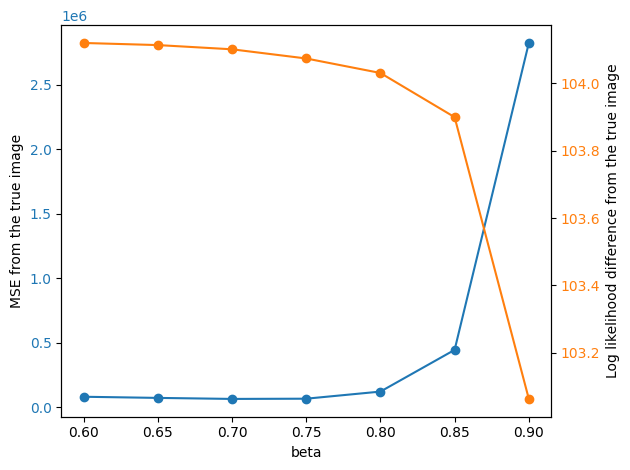

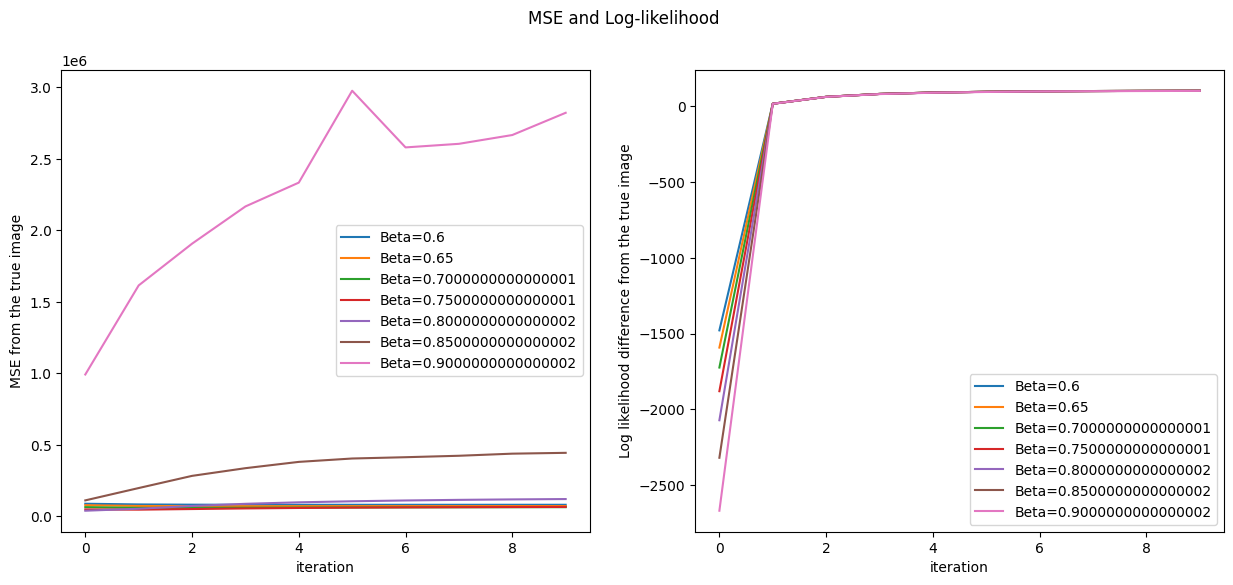

In [90]:
pet=PET(f_factor=1e5,tau=1e-9,T=0.1,beta=0.8)
pet.run_simulation()
pet.reconstruct_all_beta(beta_lst=np.arange(0.6,0.95,0.05))
pet.plot_results()

random/singles photons for each detector 0.0
avr events from pixels to detector 0.625
avr events from pixels to pair of detectors 0.0015625
Reconstruction using the new method, beta 0.6
1 llik  -395.11 diff llik 4574.86 mse 83663.65 diff mse -6751.22 f sum 24798.17
2 llik  -120.02 diff llik 275.09 mse 80096.03 diff mse -3567.62 f sum 24796.98
3 llik  1.78 diff llik 121.81 mse 78214.38 diff mse -1881.64 f sum 24793.65
4 llik  58.64 diff llik 56.85 mse 77174.37 diff mse -1040.02 f sum 24799.04
5 llik  87.12 diff llik 28.48 mse 76580.39 diff mse -593.98 f sum 24798.55
6 llik  102.42 diff llik 15.3 mse 76209.83 diff mse -370.55 f sum 24802.4
7 llik  111.19 diff llik 8.77 mse 75990.43 diff mse -219.41 f sum 24798.19
8 llik  116.51 diff llik 5.31 mse 75844.94 diff mse -145.49 f sum 24795.49
9 llik  119.89 diff llik 3.38 mse 75730.85 diff mse -114.08 f sum 24800.61
10 llik  122.13 diff llik 2.24 mse 75651.96 diff mse -78.9 f sum 24801.43
11 llik  123.67 diff llik 1.54 mse 75617.13 diff mse -3

/home/ubuntu/.local/lib/python3.8/site-packages/cvxpy/atoms/elementwise/log.py:35: RuntimeWarning: divide by zero encountered in log
  return np.log(values[0])


12 llik  125.52 diff llik 1.09 mse 45389.7 diff mse -41.09 f sum 44083.26
13 llik  126.32 diff llik 0.8 mse 45358.39 diff mse -31.31 f sum 44082.27
stopping because diff_llik=0.80<1.00
Reconstruction using the new method, beta 0.7500000000000001
1 llik  -393.92 diff llik 7917.82 mse 35289.13 diff mse -12482.67 f sum 63473.17
2 llik  -118.91 diff llik 275.01 mse 30017.57 diff mse -5271.55 f sum 63473.17
3 llik  2.91 diff llik 121.82 mse 27741.14 diff mse -2276.43 f sum 63473.82
4 llik  59.76 diff llik 56.85 mse 26684.04 diff mse -1057.1 f sum 63473.52
5 llik  88.25 diff llik 28.48 mse 26169.24 diff mse -514.8 f sum 63473.46
6 llik  103.55 diff llik 15.3 mse 25879.99 diff mse -289.25 f sum 63473.94
7 llik  112.32 diff llik 8.77 mse 25728.62 diff mse -151.37 f sum 63473.13
8 llik  117.63 diff llik 5.31 mse 25609.02 diff mse -119.61 f sum 63472.89
9 llik  121.01 diff llik 3.38 mse 25548.62 diff mse -60.4 f sum 63473.61
10 llik  123.25 diff llik 2.24 mse 25493.96 diff mse -54.66 f sum 63473

/home/ubuntu/.local/lib/python3.8/site-packages/cvxpy/atoms/affine/binary_operators.py:273: RuntimeWarning: invalid value encountered in multiply
  return np.multiply(values[0], values[1])


11 llik  125.1 diff llik 1.54 mse 15948.72 diff mse 148.11 f sum 99159.62
12 llik  126.2 diff llik 1.1 mse 16050.05 diff mse 101.33 f sum 99160.41
13 llik  127.0 diff llik 0.8 mse 16117.14 diff mse 67.09 f sum 99155.49
stopping because diff_llik=0.80<1.00
Reconstruction using the new method, beta 0.8500000000000002
1 llik  -393.16 diff llik 11812.53 mse 55200.24 diff mse 4421.63 f sum 176197.33
2 llik  -118.22 diff llik 274.94 mse 71813.13 diff mse 16612.89 f sum 176153.42
3 llik  3.25 diff llik 121.48 mse 86329.77 diff mse 14516.64 f sum 176206.4
4 llik  60.12 diff llik 56.87 mse 96169.16 diff mse 9839.39 f sum 176218.3
5 llik  88.61 diff llik 28.49 mse 102491.42 diff mse 6322.26 f sum 176196.45
6 llik  103.9 diff llik 15.29 mse 106831.1 diff mse 4339.68 f sum 176259.97
7 llik  112.65 diff llik 8.74 mse 109682.9 diff mse 2851.8 f sum 176208.35
8 llik  117.93 diff llik 5.29 mse 111949.1 diff mse 2266.2 f sum 176206.36
9 llik  121.36 diff llik 3.42 mse 113321.65 diff mse 1372.55 f sum 1

/home/ubuntu/.local/lib/python3.8/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


9 status optimal_inaccurate
9 llik  120.26 diff llik 3.36 mse 1284542.54 diff mse 10645.36 f sum 395969.18
10 status optimal_inaccurate
10 llik  122.43 diff llik 2.16 mse 1288529.62 diff mse 3987.08 f sum 396078.86
11 status optimal_inaccurate
11 llik  123.7 diff llik 1.28 mse 1298933.35 diff mse 10403.73 f sum 395960.4
12 llik  125.02 diff llik 1.32 mse 1306975.78 diff mse 8042.43 f sum 395880.16
13 llik  125.91 diff llik 0.89 mse 1316676.87 diff mse 9701.09 f sum 395944.79
stopping because diff_llik=0.89<1.00
Beta with the best MSE: 0.8000000000000002
Beta with the best log-likelihood: 0.8000000000000002 with llik 127.0 and mse  16117.14
   beta           MSE  Log-likelihood
0  0.60  7.553775e+04      125.560515
1  0.65  6.241216e+04      125.943346
2  0.70  4.535839e+04      126.324166
3  0.75  2.544406e+04      126.686287
4  0.80  1.611714e+04      126.995758
5  0.85  1.168731e+05      126.973400
6  0.90  1.316677e+06      125.913834


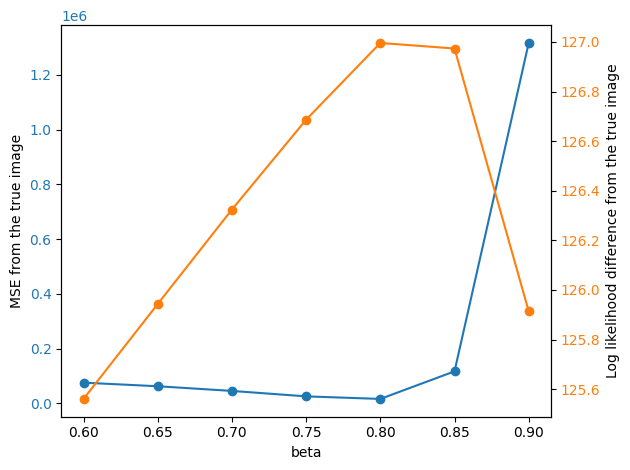

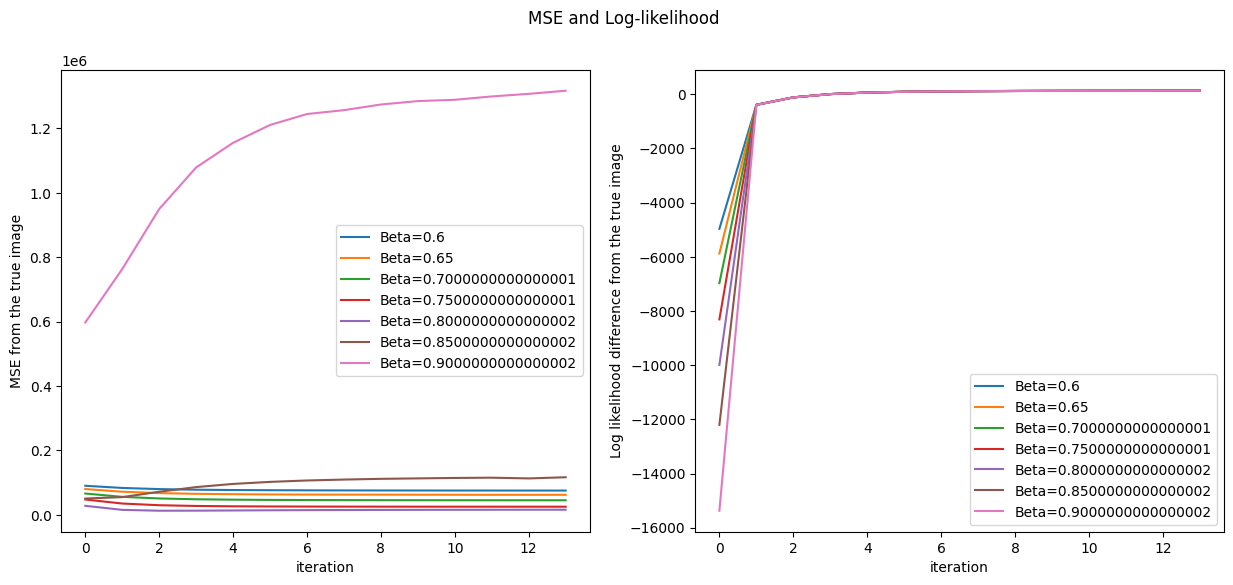

In [91]:
pet=PET(f_factor=1e5,tau=1e-9,T=1,beta=0.8)
pet.run_simulation()
pet.reconstruct_all_beta(beta_lst=np.arange(0.6,0.95,0.05))
pet.plot_results()

random/singles photons for each detector 0.0
avr events from pixels to detector 3.125
avr events from pixels to pair of detectors 0.0078125
Reconstruction using the new method, beta 0.8
1 llik  -2312.13 diff llik 47632.32 mse 256420.23 diff mse -384521.97 f sum 492852.79
2 llik  -985.88 diff llik 1326.24 mse 135154.14 diff mse -121266.09 f sum 492435.54


/home/ubuntu/.local/lib/python3.8/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


3 status optimal_inaccurate
3 llik  -403.39 diff llik 582.49 mse 98220.95 diff mse -36933.19 f sum 492321.14
4 llik  -139.84 diff llik 263.55 mse 91393.52 diff mse -6827.43 f sum 491261.22
5 llik  -13.61 diff llik 126.23 mse 86466.88 diff mse -4926.64 f sum 499492.87
6 llik  52.66 diff llik 66.27 mse 87514.28 diff mse 1047.4 f sum 491494.12
7 llik  90.25 diff llik 37.59 mse 88496.04 diff mse 981.75 f sum 491963.34
8 llik  111.22 diff llik 20.97 mse 90127.66 diff mse 1631.62 f sum 492013.24
9 llik  122.62 diff llik 11.4 mse 88398.78 diff mse -1728.88 f sum 493494.85
10 llik  134.39 diff llik 11.77 mse 89161.53 diff mse 762.75 f sum 492332.64
11 llik  137.51 diff llik 3.12 mse 86668.11 diff mse -2493.42 f sum 499774.59
12 llik  141.11 diff llik 3.6 mse 85577.09 diff mse -1091.02 f sum 492052.84
13 llik  145.53 diff llik 4.42 mse 86542.34 diff mse 965.25 f sum 499896.17


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


14 llik  144.66 diff llik -0.87 mse 85546.55 diff mse -995.79 f sum 491319.5
stopping because diff_llik=-0.87<1.00


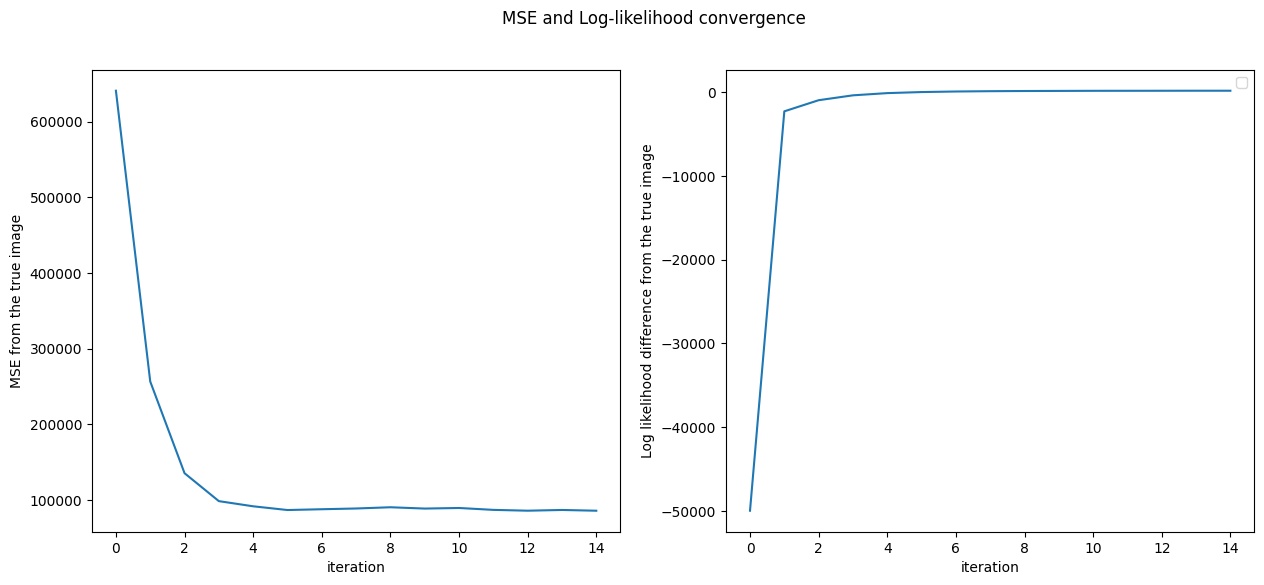

In [107]:
pet=PET(f_factor=5e5,tau=1e-9,T=1,beta=0.8)
pet.run_simulation()
pet.reconstruct_known_beta()
pet.plot_results_one_beta()

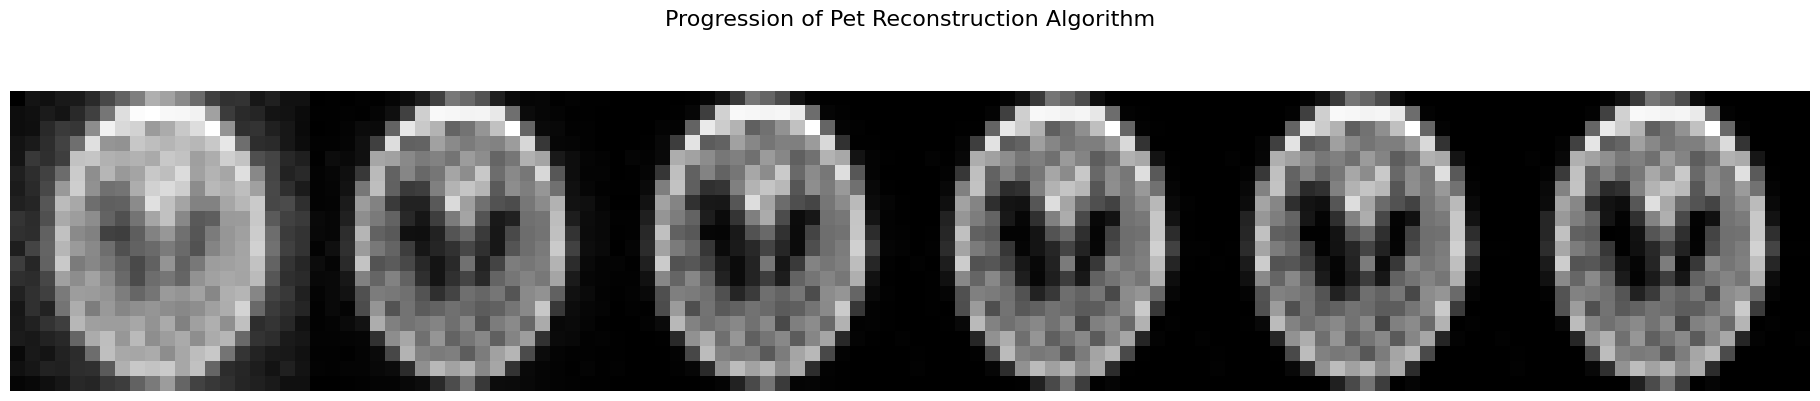

In [125]:
# Create a new figure
fig = plt.figure(figsize=(18, 4))

# Loop through the images with the specified step size and plot them
for i in range(0, len(f_lst), 3):
    ax = fig.add_subplot(1, len(f_lst) // 3, i // 3 + 1)
    ax.imshow(f_lst[i].reshape(pet.B_SQRT,pet. B_SQRT), cmap='Greys_r')
    ax.axis('off')

# Add a title to the figure
fig.suptitle('Progression of Pet Reconstruction Algorithm', fontsize=16)

# Adjust the spacing and margins
fig.subplots_adjust(wspace=0, hspace=0, left=0, right=1, top=0.8, bottom=0)

# Show the figure
plt.show()
